<a name="outline"></a>

## Outline

- [Task 1](#task-1): Regression
  - [1.1](#q11) Linear regression
  - [1.2](#q12) Ridge regression
  - [1.3](#q13) Relaxation of Lasso regression
- [Task 2](#task-2): Classification
  - [2.1](#q21) kNN classifier
  - [2.2](#q22) Random forest 
  - [2.3](#q23) Support vector machine (SVM) 
- [Task 3](#task-3): Mastery component 
  - [3.1](#q31) Logistic regression and bagging 
  - [3.2](#q32) Kernelised SVM classifier 

In [323]:
#import necessary packages
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import time
from tabulate import tabulate
import seaborn as sns
from collections import defaultdict
import sympy

<a name="task-1"></a>
# Task 1: Regression [^](#outline)



<a name="q11"></a>

## 1.1  [^](#outline)



First, we load and preview our data.

In [2]:
# load train data as pandas data frames
chem_samples = pd.read_csv('chemistry_samples.csv')
chem_samples.head()

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,FV1,VFV,FV2,FV3,LC50
0,3.661280,0.658363,1.602232,1.994272,0.836488,3.153623,15.893033,-27.724370,0.059355,0.756698,5.506249
1,3.936362,1.154287,1.146997,0.904295,2.948308,5.141095,13.590177,-31.821521,-13.408855,1.161298,6.636791
2,0.964144,0.415485,1.481028,2.136585,0.043679,-1.156783,15.989419,-3.699312,2.561525,0.500115,1.563388
3,2.074617,1.417296,0.486216,0.000908,-0.066980,2.610960,7.962046,-16.374439,2.448975,1.481888,6.248432
4,1.448569,0.836892,1.951012,0.028318,-0.039121,1.851095,22.285266,-9.526361,2.870400,0.649234,3.676796


In [3]:
# load test data as pandas data frames
chem_test = pd.read_csv('chemistry_test.csv')
chem_test.head()

,CIC0,SM1_Dz(Z),GATS1i,NdsCH,NdssC,MLOGP,FV1,VFV,FV2,FV3,LC50
0,1.617579,0.376167,1.224281,0.849464,1.101738,-0.448372,14.913614,-9.091450,-1.953849,0.328298,1.791786
1,4.278766,0.514788,1.259734,0.210436,0.819626,4.446118,12.904817,-37.986185,-2.804426,0.452758,6.125609
2,3.578652,0.221018,1.552583,1.007153,-0.013073,1.960720,17.393050,-27.188863,3.565159,0.341665,3.953270
3,3.021762,1.602774,1.044233,0.054776,2.060890,4.510903,12.777434,-22.710306,-7.966119,1.729511,6.995314
4,2.487163,0.799948,1.005727,0.094923,0.146542,2.298082,13.336721,-16.839870,2.607198,0.904353,5.253633


We see that some of our features are very highly correlated (see below) and so we may ought to implement feature drops, where we remove one of a pair of highly correlated features. The main reason to remove highly correlated features is storage and speed concerns since they often contribute to the outcomes similarly. Other than that, what matters about features is whether they contribute to prediction, and whether their data quality is sufficient. So we decide not to implement for now. Maybe if I were to have more time I could think about how I were to do this.

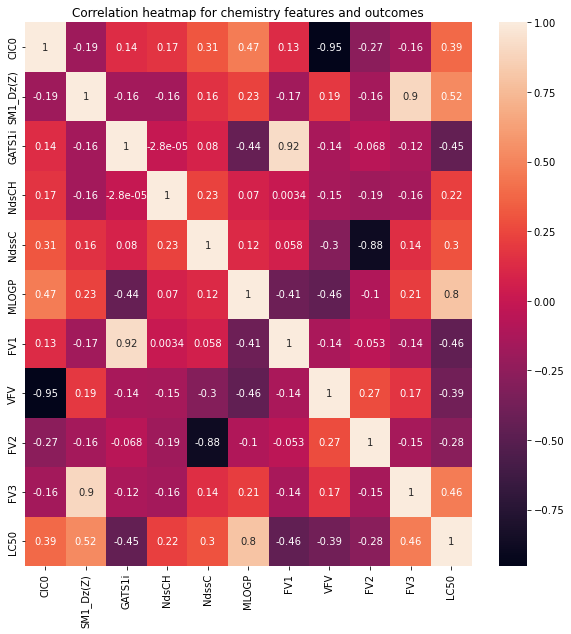

In [338]:
#correlations
plt.figure(figsize = (10,10))
corrMatrix = chem_samples.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation heatmap for chemistry features and outcomes")
plt.show()

In [339]:
#check if train data cleaning is needed
#we see there are no duplicated rows
print(np.array_equal(chem_samples.duplicated(),[False]*len(chem_samples)))
print("--------------------")
#we check that all values are floats
print(chem_samples.dtypes)
print("--------------------")
#check if test data cleaning is needed
#we see there are no duplicated rows
print(np.array_equal(chem_test.duplicated(),[False]*len(chem_test)))
print("--------------------")
#we check that all values are floats
print(chem_test.dtypes)

True
--------------------
CIC0         float64
SM1_Dz(Z)    float64
GATS1i       float64
NdsCH        float64
NdssC        float64
MLOGP        float64
FV1          float64
VFV          float64
FV2          float64
FV3          float64
LC50         float64
dtype: object
--------------------
True
--------------------
CIC0         float64
SM1_Dz(Z)    float64
GATS1i       float64
NdsCH        float64
NdssC        float64
MLOGP        float64
FV1          float64
VFV          float64
FV2          float64
FV3          float64
LC50         float64
dtype: object


We have checked for dupicated rows and checked that all the data values are floats in the dataframe. Since we do not know anything about the floats themselves in relation to the physical quanitities we assume that this data is clean and we proceed to work with it.

The naive approach of data preparation applies transformations on the whole dataset (test + train) prior to evaluating the performance of the model resulting in a problem referred to as data leakage, where information of the hold-out test set leaks into the dataset used to train the model. This may result in an incorrect estimate of model performance when making predictions on new data.\
This motivates our application of feature standardisation in the preprocessing stage of linear regression. 
$$Xtrain_i = \frac{Xtrain_i - mean(Xtrain_i)}{\sqrt{var(Xtrain_i)}}, Xtest_i = \frac{Xtest_i - mean(Xtrain_i)}{\sqrt{var(Xtrain_i)}} \quad \forall i \quad \text{(subscript i indicates ith column)}$$
$$Ytrain_i = \frac{Ytrain_i - mean(Ytrain_i)}{\sqrt{var(Ytrain_i)}}, Ytest_i = \frac{Ytest_i - mean(Ytrain_i)}{\sqrt{var(Ytrain_i)}} \quad \forall i $$
This is further helpful since we know nothing about the predictor measurement scales. For example, if our predictors have a large difference in unit measurement in which they are given to us then this can lead to the feature with the larger unit measurement to dominate the other features and so will introduce a heavier weighting in the corresponding features parameter which will influence the prediction ,when modelling on test data, more than it necessarily should. Strictly speaking, feature standardisation is least neccessary for linear least squares regression, in which we obtain the parameter analytically, out of all of the models that we will use in this coursework but it is good practice, and certainly not detrimental since it does not affect your statistical inference, to apply it. The size of the training data set is much larger than the test data, hence the estimates of mean and variance extracted from the larger data set are reliable. Further, it easier to interpret the intercept term as the expected value of Y when the predictor values are set to their means.

In [5]:
#return a standardised array (used for train set), remembering shifts so that these can be applied to the test
def standardise(X):
    params = []
    stdX = np.empty(X.shape)
    for i in range(X.shape[1]):
        #standardizing each column
        mu = np.mean(X[:,i])
        std = np.std(X[:,i])
        stdX[:,i] = (X[:,i] - mu) / std
        params.append((mu,std))
        
    return stdX, params

In [107]:
#convert data to arrays
train = chem_samples.to_numpy()
test = chem_test.to_numpy()
#standardize both train and test (including outcomes)
stdtrain, params = standardise(train)
stdtest = np.empty(test.shape)
for i in range(test.shape[1]):
    mu, sig = params[i]
    stdtest[:,i] = (test[:,i] - mu)/sig
#separating the data samples into the predictors and out comes
stdXtrain = train[:,:-1]
stdYtrain = train[:,-1]
stdXtest = test[:,:-1]
stdYtest = test[:,-1]
#randomly permute train data, in case it was ordered in some way
np.random.seed(23)
p = np.random.permutation(stdXtrain.shape[0])
stdXtrain = stdXtrain[p]
stdYtrain = stdYtrain[p]

Our data is now in the standardised form $$\{x_1^{(i)},\dots, x_{10}^{(i)}, y^{(i)}\}_{i=1}^{4111}(std)$$
and say we have the belief that $$y = \beta_0 + \beta_1x_1 + \dots + \beta_{10}x_{10} + \epsilon \quad (std) \quad \text{where} \quad \epsilon \in \mathbb{R}^{4111}, \epsilon_i \sim N(0,\sigma^2) \text{iid}$$
Then we obtain the linear model paramatrized by $\beta \in \mathbb{R}^{11}$
$$\hat{y} = \beta_0 + \beta_1x_1 + \dots + \beta_{10}x_{10}\quad (std)\quad \beta = [\beta_0 \dots \beta_{10}]^T$$ We decide to include a constant term (i.e., the intercept), since this ensures that the model will be unbiased (the mean of the residuals will be exactly zero.)

We will find the parameters $\boldsymbol\beta$ that optimize the following equation:
$$
\underset{\boldsymbol\beta}{\text{min}} \| \mathcal Y - \mathcal X \boldsymbol\beta \|^2 = \underset{\boldsymbol\beta}{\text{min}} \ \text{L}_{\text{LS}} (\boldsymbol\beta)
$$
where $\text{L}_{\text{LS}}$ is the (ordinary) least squares loss function. As we know from lectures, the solution is
$$
\boldsymbol\beta^{*} = (\boldsymbol X^T\boldsymbol X)^{-1}\boldsymbol X^T\boldsymbol y \ \in\mathbb{R}^{11}\,,
$$
where 
$$
\boldsymbol X = [\boldsymbol x_1, \ldots, \boldsymbol x_{4111}]^T\in\mathbb{R}^{4111\times 11}\,,\quad \boldsymbol y = [y_1, \ldots, y_{4111}]^T \in\mathbb{R}^{4111}\,.
$$
Note: In the functions we will always enter the standardised data without the intercept term and in function we concatenate the constant terms.

In [108]:
#return least squares beta parameter
def beta_lr(X, y):
    
    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: parameter for ls regression (including intercept) ((D + 1) x 1)
    
    X_aug = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    beta_ml = np.linalg.solve(X_aug.T @ X_aug, X_aug.T @ y)
    return beta_ml

In [109]:
beta_ls = beta_lr(stdXtrain,stdYtrain)
print("Linear regression beta:\n",beta_ls)

Linear regression beta:
 [ 2.61638041e+00  4.47138333e-02  1.25871884e+00 -3.80092766e-02
  3.63073448e-01  4.66534885e-03  3.90510052e-01 -7.46028629e-02
 -3.57069460e-02 -1.52588258e-02 -1.80315940e-03]


We know need to show that $\beta^*$ is indeed the minimum least squares solution, which we know involes showing that the Hessian is positive definite. From the notes we know for the linear regression case specifically we have $$H = \frac{2}{N}X^TX$$

In [110]:
#defining hessian for linear regression case
def hess(X):
    X_aug = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    return 2 / X_aug.shape[0] * X_aug.T @ X_aug

We know a matrix M is positive-definite if and only if M is congruent with a diagonal matrix with positive real entries. So we try to diagonalise the hessian matrix to see if the diagonal matrix has only positive real entries using SymPy.

In [194]:
#diagonalising the hessian matrix
M = Matrix(hess(stdXtrain))
P, D = M.diagonalize()
print(D)

Matrix([[1550.22055269579, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 61.5801619176760, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 38.2644137856274, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 3.11472003416592, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.982893916812969, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.131030439498831, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.0334118414213938, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0.0407246591547938, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0.0550761329122135, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0.351343619178415, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.606838251887268]])


As we can see the above criteria is fulfilled and so the Hessian is positive definite and hence $\beta^*$ is indeed the minimum solution.

In [112]:
#predict xtest data using linear regression parameter from train data
def predict_with_estimate(X_test, beta):
    
    # X_test: K x D matrix of test inputs
    # beta: D x 1 vector of parameters
    # returns: prediction of f(X_test); K x 1 vector
    K, D = X_test.shape
    X_aug = np.hstack([np.ones((K,1)), X_test]) # augmented training inputs of size N x (D+1)
    
    prediction = X_aug @ beta
    
    return prediction 

We define the coefficient of determination, $R^2$, which we use as a goodness-of-fit measure for our model. It measures the proportion of the variation in the dependent variable that is predictable from the independent variables, and so provides a measure of how well observed outcomes are replicated by the model, based on the proportion of total variation of outcomes explained by the model.
$${\displaystyle SS_{\text{res}}=\sum _{i}(y_{i}-f_{i})^{2}=\sum _{i}e_{i}^{2}\,}$$ $${\displaystyle SS_{\text{tot}}=\sum _{i}(y_{i}-{\bar {y}})^{2}}$$
$${\displaystyle R^{2}=1-{SS_{\rm {res}} \over SS_{\rm {tot}}}}$$

In [47]:
#defining R^2 coefficient of determination
def Rsquared(X,y,beta):
    ybar = np.mean(y)
    yhat = predict_with_estimate(X,beta)
    errs = yhat - y
    RSS = np.dot(errs,errs)
    TSS = np.dot(y-ybar,y-ybar)
    return 1 - RSS/TSS

As we know from lectures the prediction of test data will take the following form $$\hat{y}_{test} = X_{test} \beta^*$$ 
But here we have used the shifted test data and our parameters are also derived from the shifted train data meaning that these predictions have not the desired interpretation. In order to obtain the desired prediction using the test data we need to reverse shift $\hat{y}_{test}$. So the original scale prediction (what we really want to return) is given by $\hat{y}_{test} \times std(y_{train}) + mu(y_{train})$

In [113]:
#calculate predictions using acquired model
yhattest = predict_with_estimate(stdXtest, beta_ls)
print("Standardised predictions for test data:\n",yhattest)
ymu, ystd = params[-1]
yhattestactual = yhattest * ystd + ymu
print("Original scale predictions for test data:\n",yhattestactual)
print("Original scale true test data outcomes:\n",stdYtest * ystd + ymu)

Standardised predictions for test data:
 [2.4953788  5.65988436 3.74511693 ... 4.30643685 4.45504931 2.40315046]
Original scale predictions for test data:
 [ 7.15010868 10.96745541  8.65766923 ...  9.33479011  9.51406149
  7.03885353]
Original scale true test data outcomes:
 [ 6.30136443 11.52925949  8.90876498 ...  9.72649369  8.77945567
  6.76982463]


In [114]:
insamplersquared = Rsquared(stdXtrain,stdYtrain,beta_ls)
print("In-sample R^2 score:", insamplersquared)

In-sample R^2 score: 0.8718259975718016


In [115]:
#calculate Out-of-sample R^2 score using prior built Rsquared function
outofsamplersquared = Rsquared(stdXtest,stdYtest,beta_ls)
print("Out-of-sample R^2 score:", outofsamplersquared)

Out-of-sample R^2 score: 0.8642933369927281


In [116]:
#comparing in and out-of R^2 scores
print("Out-of-sample R^2 score:", outofsamplersquared, "<", "In-sample R^2 score:", insamplersquared)

Out-of-sample R^2 score: 0.8642933369927281 < In-sample R^2 score: 0.8718259975718016


In [117]:
lsrsquareddata = [["In-sample R^2 score","Out-of-sample R^2 score"],[insamplersquared,outofsamplersquared]]
print(tabulate(lsrsquareddata,headers='firstrow',tablefmt='fancy_grid'))

╒═══════════════════════╤═══════════════════════════╕
│   In-sample R^2 score │   Out-of-sample R^2 score │
╞═══════════════════════╪═══════════════════════════╡
│              0.871826 │                  0.864293 │
╘═══════════════════════╧═══════════════════════════╛


As stated above, $R^2$ is a goodness-of-fit measure for linear regression models. This statistic indicates the percentage of the variance in the dependent variable that the independent variables explain collectively. $$R^2 = \frac{\text{Variance explained by model}}{\text{Total variance}}, 0 \leq R^2 \leq 1$$
Normally, the greater the $R^2$, the better the regression model fits your observations. Since the model was trained upon the train data we expect the in-sample $R^2$, which measures the goodness-of-fit of the model on the data used to train it, score to be larger than the out-of-sample $R^2$ score which measures the goodness-of-fit of the same model on the test data, which is not used in training the model. This is since variance in the outcomes of the train data is directly dependent on the relationship with the train predictors which we picture below. So the train data predictors can explain more of the variance in the outcomes of train data rather than the test data. 

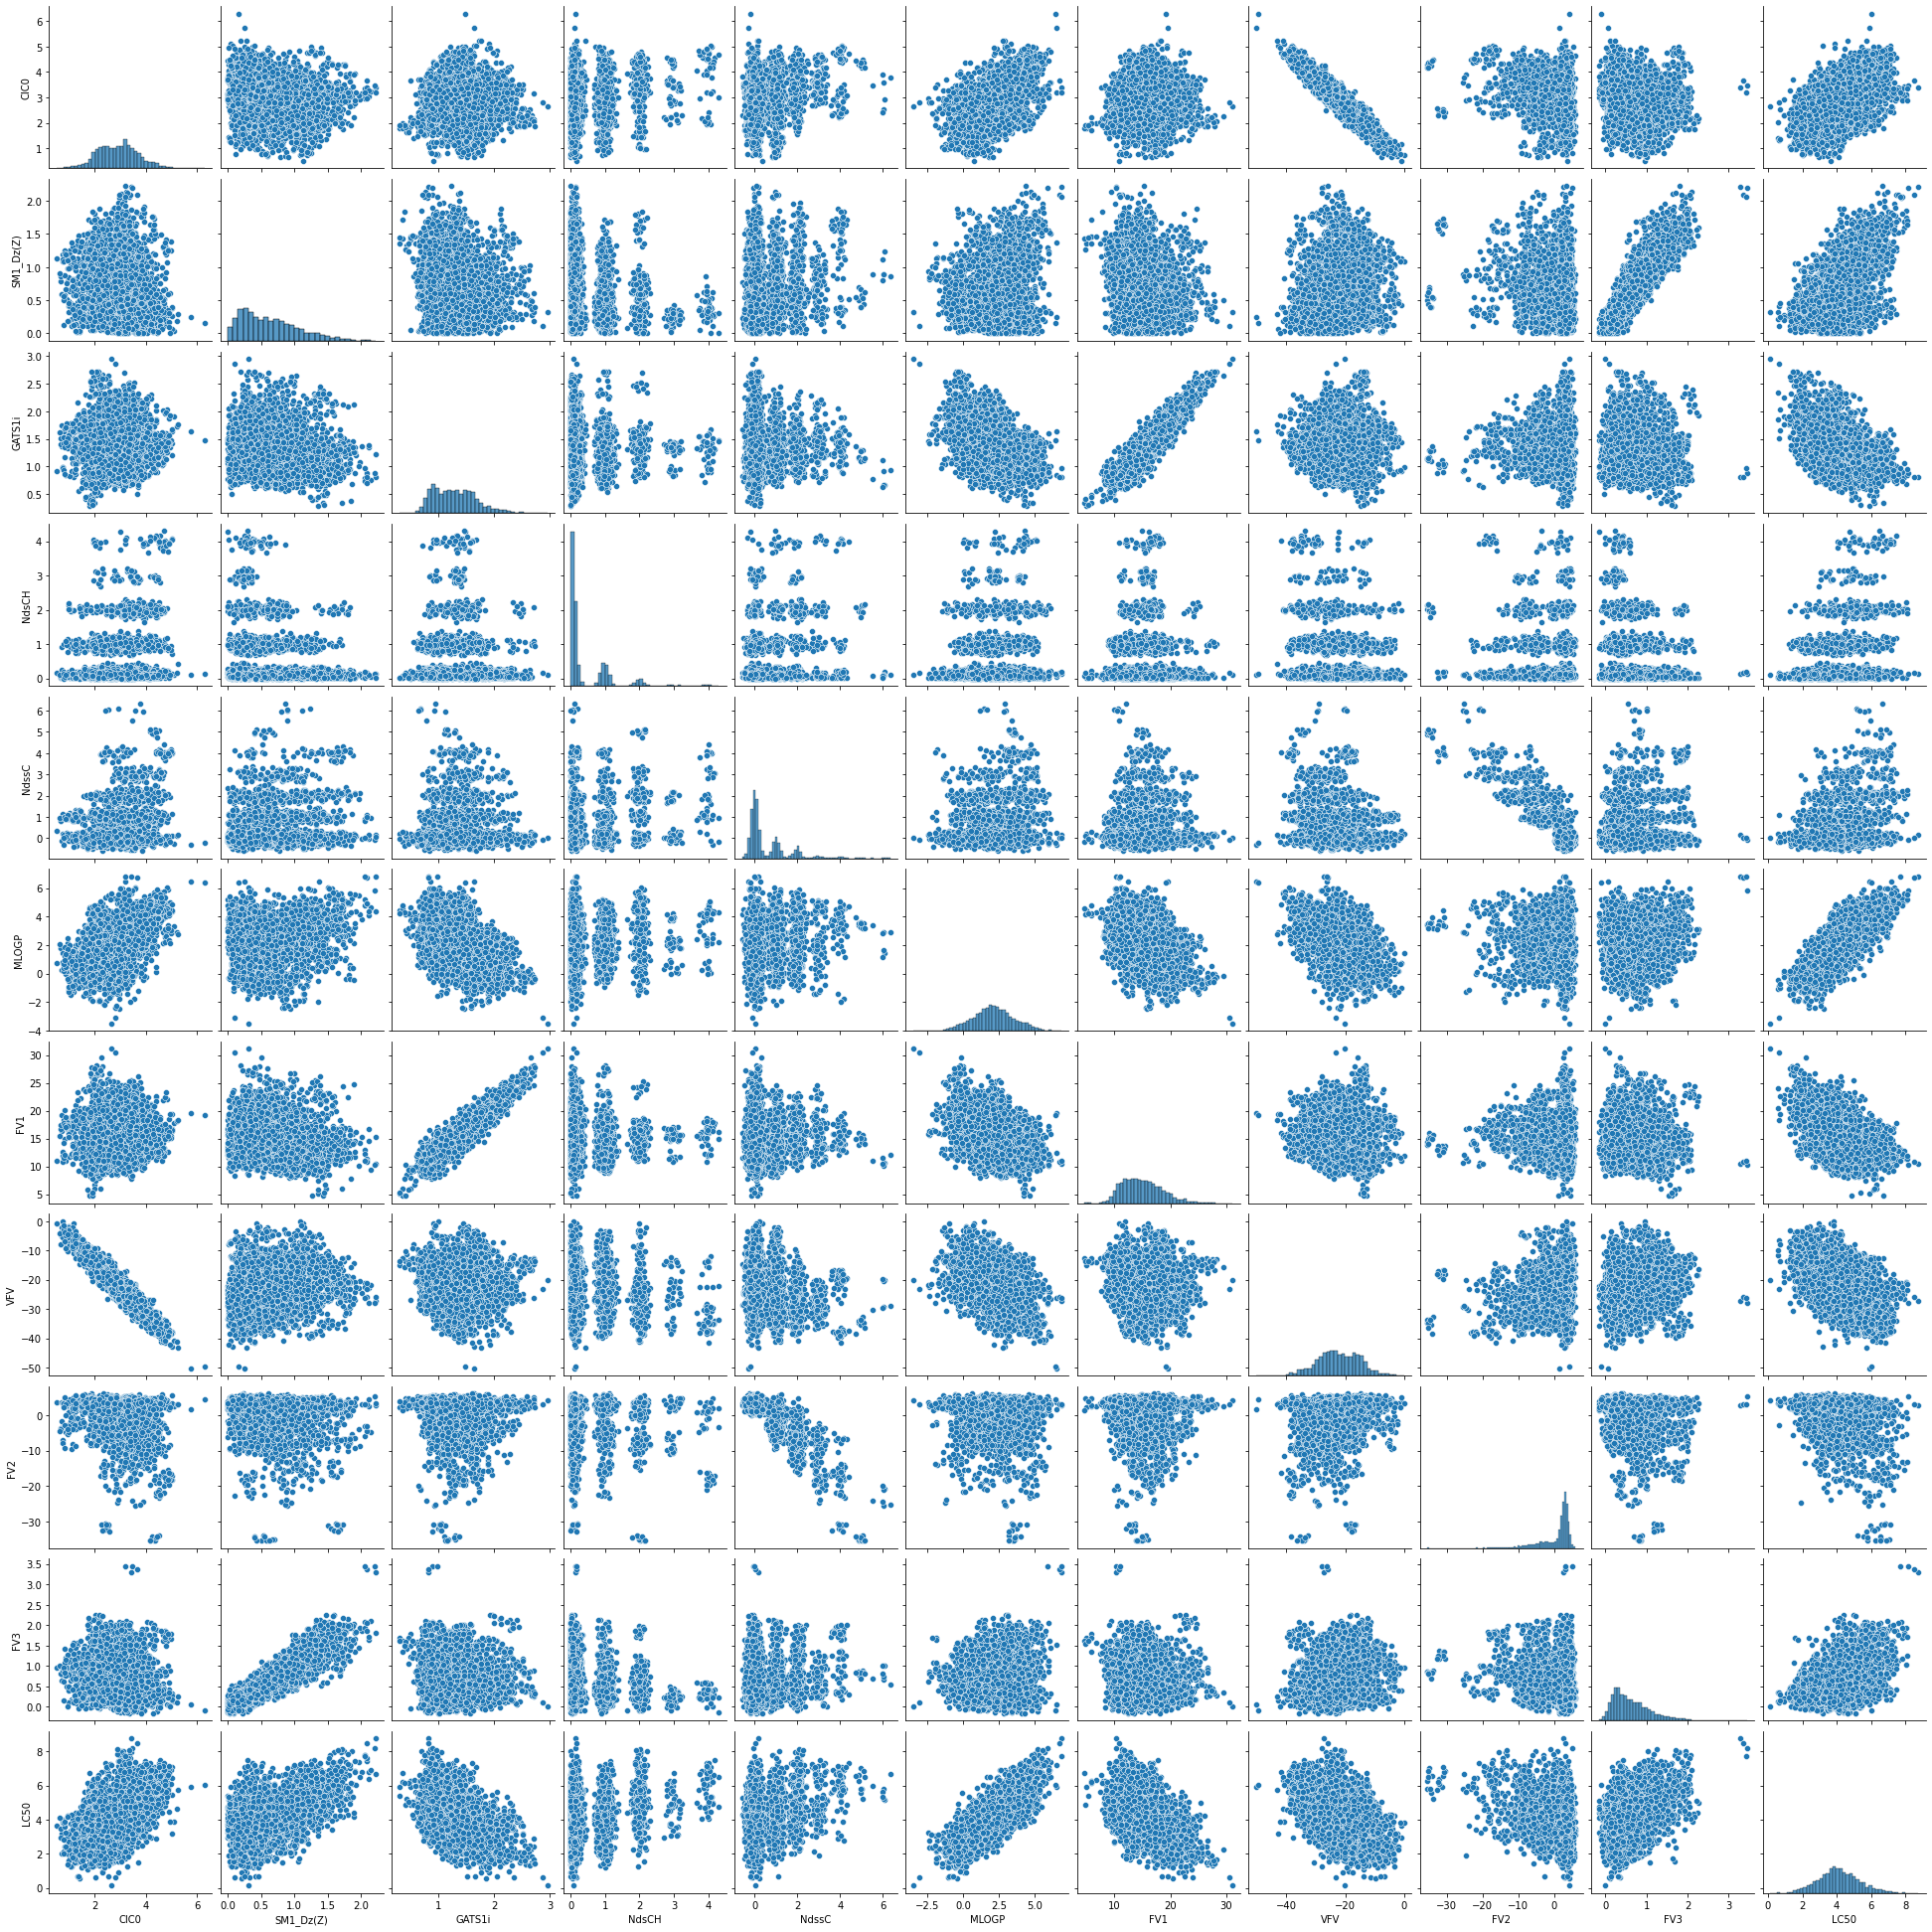

In [53]:
#plot of pairwise realtionships in the sample data 
#last row is particularly insightful as it shows the relationship between the outcomes and each predictor 
sns.pairplot(chem_samples);

<a name="q12"></a>
## 1.2 [^](#outline)

Importantly, the way we think about ridge regression is by creating a hyper-sphere which constrains the size of our regression parameters coefficients. The radius of the hyper-sphere is dependent on the regularisation term $\lambda$, the greater the $\lambda$ the smaller the radius and hence the closer the coefficients to 0. Hence, the term shrinkage method. Thinking visually about bias and variance, we understand that shrinking the size of the hyper-sphere brings the parameter coefficients closer to each other, hence reducing variance, but also moves the estimated parameter coefficients further away from the true value, hence increasing bias.\
From our lectures, we know that ridge regression is an extension of linear regression with least squares loss function, including a (usually small) positive penalty term $\lambda$:
$$
\underset{\boldsymbol\beta}{\text{min}} \| \mathcal Y - \mathcal X \boldsymbol\beta \|^2 + \lambda \| \boldsymbol\beta \|^2 = \underset{\boldsymbol\beta}{\text{min}} \ \text{L}_{\text{ridge}} (\boldsymbol\beta)
$$
where $\text{L}_{\text{ridge}}$ is the ridge loss function. The solution is
$$
\boldsymbol\beta^{*}_{\text{ridge}} = (\boldsymbol X^T\boldsymbol X + \lambda I_{pp})^{-1}\boldsymbol X^T\boldsymbol y \, \quad \text{where $I_{pp}$ is identity matrix with 0 in position (0,0)}$$
The introduction of the 0 in the (0,0) position is to improve the shrinkage properties of ridge regression so that it is not dominated by large values of the intercept of the linear model (the $\beta_0$ does not pass through penalty term).\
What we hope to achieve with ridge regression is a lower MSE in our model application. This regularisation penalty term introduces a bias, contrary to the unbiased ordinary least squares parameter, but seeks to reduce variance, as outlined above.

During ridge regression, it is even more important to feature standardise as we already have done. This results in the values in each column having mean zero, and variance one. We still have the motivation from ordinary least squares feature standardisation valid here but now we have the regularisation term involved which adds more reasons to feature standardise. If we do not set the mean of each column to zero, then regularization biases the model away from the data which is something very undesirable since in the worst case our simplest models should aim for the average data point. Without feature standardisation, they do not. If we have variance of some features to be different from others, ridge regression will penalise some features more than others. The penalty term regularize the linear regression by imposing a constraint on the size of coefficients. Thus the coefficients are shrunk toward zero and toward each other. But if the independent variables have not been standardised, the shrinking is not fair.

In [118]:
#get indexes for 5 folds (last fold has extra sample but this is completely fine)
def get_fold_ind(ytrain,k):
    return [int(i) for i in (np.round(np.linspace(0,len(ytrain),k+1)))]
get_fold_ind(stdYtrain,5)

[0, 822, 1644, 2467, 3289, 4111]

In [119]:
def ridge_estimate(X, y, lam):
    
    # X: N x D matrix of training inputs
    # y: N x 1 vector of training targets/observations
    # returns: maximum likelihood parameters (D x 1)
    
    N, D = X.shape
    X_aug = np.hstack([np.ones((N,1)), X]) # augmented training inputs of size N x (D+1)
    N_aug, D_aug = X_aug.shape
    I = np.identity(D_aug)
    I[0,0] = 0
    beta_ridge = np.linalg.solve(X_aug.T @ X_aug + lam * I, X_aug.T @ y).reshape(-1,1)
    return np.squeeze(beta_ridge)
#get beta using ridge regression with given lambda

#we see for lam=0 we get the beta star paramater from LS regression as expected
ridge_estimate(stdXtrain,stdYtrain,0)


array([ 2.61638041e+00,  4.47138333e-02,  1.25871884e+00, -3.80092766e-02,
        3.63073448e-01,  4.66534885e-03,  3.90510052e-01, -7.46028629e-02,
       -3.57069460e-02, -1.52588258e-02, -1.80315940e-03])

We define the MSE that will be used as a score measure in cross validation.$${\displaystyle \operatorname {MSE} ={\frac {1}{n}}\sum _{i=1}^{n}(Y_{i}-{\hat {Y_{i}}})^{2}}{\displaystyle ={\frac {1}{n}}\sum _{i=1}^{n}(e_{i})^{2}={\frac {1}{n}}\mathbf {e} ^{\mathsf {T}}\mathbf {e} }$$

In [120]:
#get MSE of test set using ridge regression with given lambda
def ridge_MSE(xtrain,ytrain,xtest,ytest,lam):
    e = ytest - predict_with_estimate(xtest,ridge_estimate(xtrain,ytrain,lam))
    return 1/len(ytest) * np.dot(e,e)

In [121]:
#linear regression MSE (since no penalty term)
ridge_MSE(stdXtrain,stdYtrain,stdXtest,stdYtest,0)

0.18737828211801524

In [122]:
#cross validate using precalculated fold indexes and given lambda on X,y set
def cross_validation(X,y,indexes,lam):
    MSEs = []
    #loop over each fold as validation set and complement being train set
    for i in range(len(indexes)-1):
        #get indexes for validation set and the complement
        validindex = np.arange(indexes[i],indexes[i+1])
        invalidindex = list(set(range(len(y)))-set(validindex))
        #get validation set and complement
        vX = X[validindex,:]
        vy = y[validindex]
        nvX = X[invalidindex,:]
        nvy = y[invalidindex]
        #append MSE for current validation set
        MSEs.append(ridge_MSE(nvX,nvy,vX,vy,lam))
    #return average MSE over all validation sets
    return np.mean(MSEs)

In [123]:
#loop over various penalties and select lambda with lowest mean MSE from cross validation
def get_best_lam(X,y,indexes,lamrange,show=False):
    meanMSEs = []
    #cross validate with given lambda
    for lam in lamrange:
        meanMSEs.append(cross_validation(X,y,indexes,lam))
    #get lambda with minimum MSE and min MSE itself
    out = (lamrange[np.argmin(meanMSEs)],min(meanMSEs))
    #plotting the cross validation MSEs for all these lambdas
    if show:
        plt.figure(figsize=(15, 8))
        plt.plot(lamrange,meanMSEs)
        plt.scatter(out[0],out[1],color='red',marker="x",label="Minimum")
        plt.xlabel("lambda")
        plt.ylabel("Mean MSE from cross validation")
        plt.title("Scan of penalty hyper-parameter to find its optimal value")
        plt.legend()
        plt.show()
    
    return out

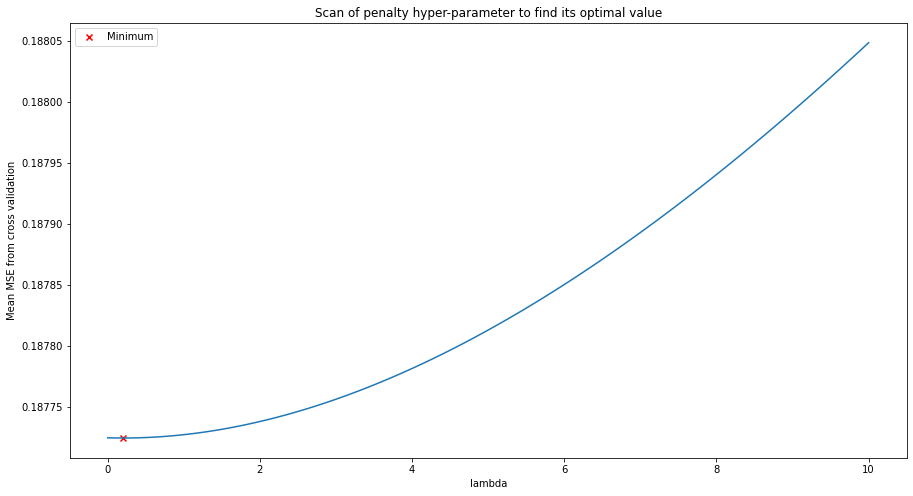

0.20202020202020202 0.18772445675823807


In [124]:
#first we get a general idea of which is the optimum lambda
l1, _ = get_best_lam(stdXtrain,stdYtrain,get_fold_ind(stdYtrain,5),np.linspace(0,10,100),show=True)
print(l1,_)

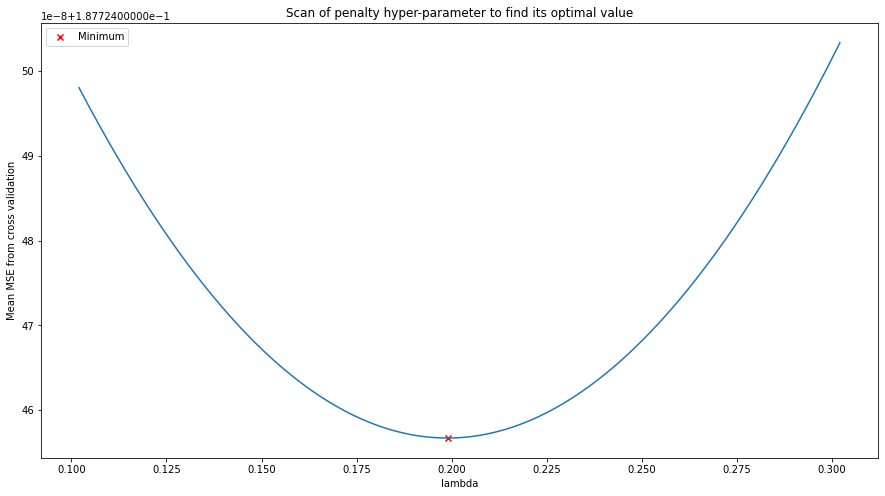

0.1989170989170989 0.18772445671424803


In [125]:
#next we refine and check the lambda for values around the first scan
l2, _ = get_best_lam(stdXtrain,stdYtrain,get_fold_ind(stdYtrain,5),np.linspace(l1-.1,l1+.1,1000),show=True)
print(l2,_)

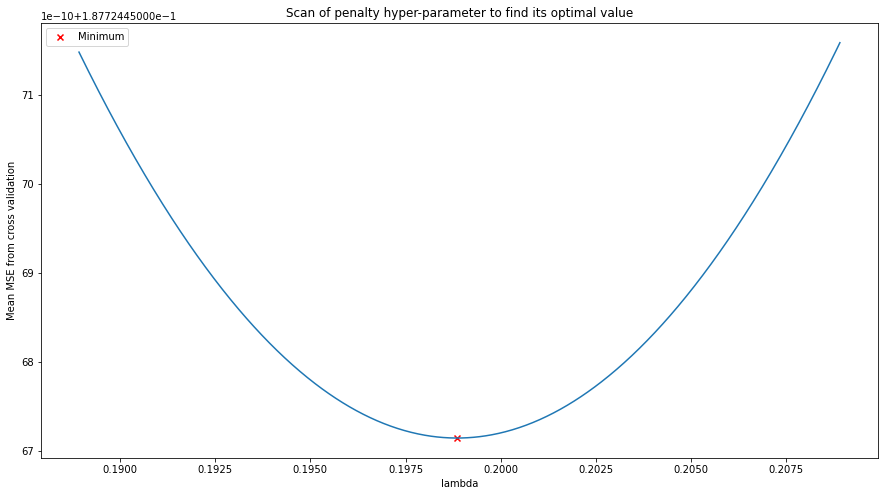

0.19884702884702884 0.18772445671423157
The optimum penalty is: 0.19884702884702884 which gives a MSE of : 0.18772445671423157


In [126]:
#we repeat this again with an even finer interval and take this to be the optimum penalty
opt_lam, opt_lam_MSE = get_best_lam(stdXtrain,stdYtrain,get_fold_ind(stdYtrain,5),np.linspace(l2-1e-2,l2+1e-2,1000),show=True)
print(opt_lam, opt_lam_MSE)
print("The optimum penalty is:",opt_lam, "which gives a MSE of :",opt_lam_MSE)

In [127]:
beta_ridge_star = ridge_estimate(stdXtrain,stdYtrain,opt_lam)
beta_ridge_star

array([ 2.61689882e+00,  4.46061915e-02,  1.25690179e+00, -3.79505073e-02,
        3.62995204e-01,  4.74696015e-03,  3.90550998e-01, -7.46124372e-02,
       -3.57077371e-02, -1.52556806e-02, -3.85025526e-04])

First we derive the bias of the ridge regression parameter ${\beta}_{ridge}^*$ as a function of the hyper-parameter $\lambda$.
$$E[{\beta}_{ridge}^*(\lambda)]=E[(X^TX+\lambda I_{pp})^{-1}X^TY] = (X^TX+\lambda I_{pp})^{-1}X^TE[Y]=(X^TX+\lambda I_{pp})^{-1}(X^TX)\beta=\beta-\lambda(X^TX+\lambda I_{pp})^{-1}I_{pp}\beta$$
$$\Rightarrow {\operatorname {Bias} ({{\beta_{ridge}^*}},\beta_{ridge})} = E[{\beta}_{ridge}^*(\lambda)] - \beta = -\lambda(X^TX+\lambda I_{pp})^{-1}I_{pp}\beta$$
We observe that $\lim_{\lambda \to \infty} {\operatorname {Bias} ({{\beta_{ridge}^*}},\beta_{ridge})} = -\beta, \text{since } \lim_{\lambda \to \infty} E[\beta_{ridge}^*(\lambda)] = 0$\
Before we derive the variance of the ridge regression parameter we obtain a relation between the minimising parameters in the ordinary least squares and ridge regression. $$\text{Define linear operator} \quad W_\lambda = (X^TX+\lambda I_{pp})^{-1}X^TX$$
$$W_\lambda \beta^* = W_\lambda (X^TX)^{-1}X^TY = (X^TX+\lambda I_{pp})^{-1}X^TX(X^TX)^{-1}X^TY=(X^TX+\lambda I_{pp})^{-1}X^TY = \beta_{ridge}^*(\lambda)$$
Now we may derive the variance for the ridge regression parameter
$$Var[\beta_{ridge}^*(\lambda)]=Var[W_\lambda \beta^*]= W_\lambda Var(\beta^*)W_\lambda^T=\sigma^2 W_\lambda (X^TX)^{-1}W_\lambda^T=\sigma^2 (X^TX+\lambda I_{pp})^{-1}X^TX[(X^TX+\lambda I_{pp})^{-1}]^T$$
We observe that $\lim_{\lambda \to \infty} {\operatorname {Var} _{\beta }({\beta_{ridge}^*(\lambda) })} = \underline{0}$


We provide the definition of MSE whose trend as a dependency on the hyper-parameter we will study below. $${\displaystyle \operatorname {MSE} ({\hat {\beta }})=\operatorname {Var} _{\beta }({\hat {\beta }})+\operatorname {Bias} ({\hat {\beta }},\beta )^{2}}$$

In [128]:
#get bias of ridge parameter based on lambda
def ridge_bias(X,y,lamb):
    N, D = X.shape
    X_aug = np.hstack([np.ones((N,1)), X]) # augmented training inputs of size N x (D+1)
    XX = X_aug.T @ X_aug
    I = np.eye(XX.shape[0])
    I[0,0] = 0
    biasvector = - lamb * np.linalg.inv(XX + lamb*I) @ I @ beta_ls
    #return the sum of squares of each bias in the vector
    return np.dot(biasvector,biasvector)

In [129]:
ridge_bias(stdXtrain,stdYtrain,0)

0.0

In [130]:
def ridge_covariance(X, y, penalty):
    N, D = X.shape
    X_aug = np.hstack([np.ones((N,1)), X]) # augmented training inputs of size N x (D+1)
    N_aug, D_aug = X_aug.shape
    I = np.eye(D_aug)
    I[0,0] = 0
    #get mean y prediction using ridge parameter
    meanpreds = np.mean(predict_with_estimate(X, ridge_estimate(X, y, penalty)))
    errs =  predict_with_estimate(X, ridge_estimate(X, y, penalty)) - meanpreds
    sample_error_variance = np.dot(errs,errs) / (N_aug - D_aug)
    covariancemat = sample_error_variance * np.linalg.inv(X_aug.T @ X_aug + penalty * I) @ X_aug.T @ X_aug @ (np.linalg.inv(X_aug.T @ X_aug + penalty * I)).T
    return covariancemat

In [131]:
ridge_covariance(stdXtrain,stdYtrain,0)

array([[ 1.44673562e-02, -3.18312730e-03, -2.33324955e-03,
         2.92032645e-03, -2.93993138e-04, -3.26563356e-04,
        -2.21889948e-04, -7.27945371e-04, -2.04360793e-04,
        -1.63335007e-04,  9.60243769e-05],
       [-3.18312730e-03,  5.69318675e-03,  4.56659116e-04,
        -2.39381891e-04, -1.35888465e-04, -1.31039995e-04,
        -2.02820714e-04, -1.12061640e-05,  5.65804899e-04,
        -3.05717678e-06, -1.81147425e-04],
       [-2.33324955e-03,  4.56659116e-04,  9.25487390e-03,
        -1.33196307e-04,  2.06084125e-04, -3.76579843e-04,
        -2.79284578e-04,  1.86238395e-05, -1.44727473e-05,
        -1.36196575e-05, -7.22100617e-03],
       [ 2.92032645e-03, -2.39381891e-04, -1.33196307e-04,
         1.33931710e-02,  4.46687355e-05, -2.11543178e-04,
         5.14065534e-04, -1.28014352e-03,  4.50040050e-05,
        -2.68264062e-05, -3.08290343e-04],
       [-2.93993138e-04, -1.35888465e-04,  2.06084125e-04,
         4.46687355e-05,  7.15236270e-04, -1.65769536e-04,
  

In [132]:
#plot trend of bias, variance and MSE as a function of the penalty hyper-parameter
def plotbiascovmse(lrange):
    biass = []
    covs = []
    mses = []
    plt.figure(figsize = (15,10))
    #find bias, var and mse for each penalty term
    for l in lrange:
        bias = ridge_bias(stdXtrain,stdYtrain,l)
        biass.append(bias)
        var = np.trace(ridge_covariance(stdXtrain,stdYtrain,l))
        covs.append(var)
        #from mse definition
        mse = var + bias ** 2
        mses.append(mse)
    plt.plot(lrange,biass,label="Bias")
    plt.plot(lrange,covs,label="Variance")
    plt.plot(lrange,mses,label="MSE")
    plt.legend()
    plt.xlabel("$\lambda$")
    plt.title("Trend of bias, variance and MSE as a function of the penalty hyper-parameter")
    plt.show()

We inspect the trend of bias, variance and MSE as a function of the penalty hyper-parameter for small $\lambda$ initially.

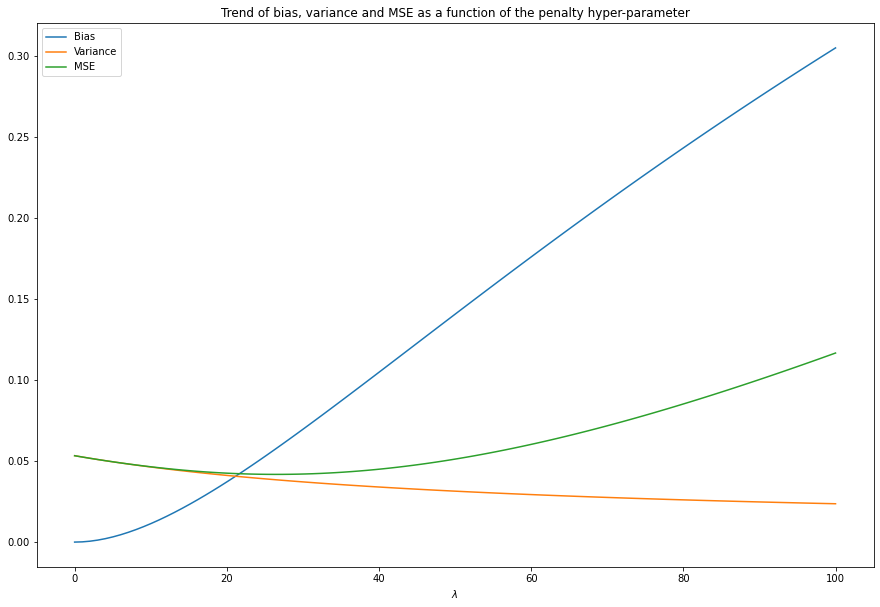

In [133]:
plotbiascovmse(np.linspace(0,100,100))

We see that at $\lambda=0$ where the ridge regression parameter is equivalent to the ordinary least squares parameter, since there is no constraint on the coefficient sizes, we have 0 bias as expected, since we know that the ordinary least squares parameter is unbiased. Hence, at this point the MSE is equal to the variance. Then as lambda increases the constraint for the ridge regression parameter coefficent shrinks which means all the coefficients becomes closer to 0 and hence closer together, decreasing the variance but since all the coefficients are shrunk they get further away from the true parameter coefficients meaning bias increases.

Next, we inspect the trend of bias, variance and MSE as a function of the penalty hyper-parameter as $\lambda$ tends to large values.

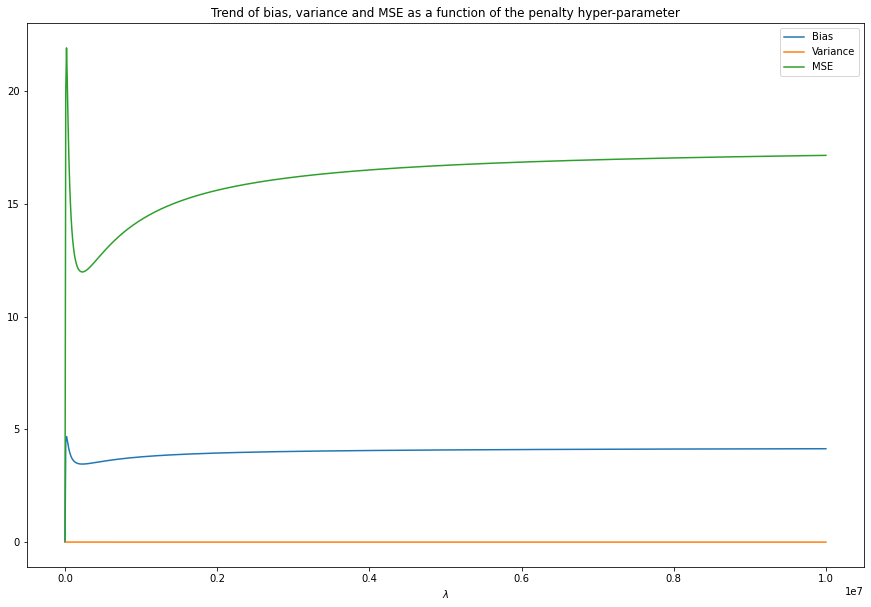

In [134]:
plotbiascovmse(np.linspace(0,10000000,1000))

By increasing $\lambda$ largely, our constraint shrinks so much that the hyper-sphere in which the coefficients are located in is near to having negligible size, and hence all of our coefficients shrink to negligible size. Via the geometrical thinking of variance, we see that all of coefficients must be near equal to 0 and hence one another and so the variance must tend to 0. As $\lambda$ increases further, the regression parameter coefficient distances from their true values increase negligibly and hence the bias eventually becomes constant, as observed above in the derivation of bias of $\beta_{ridge}^*$. Since the variance tends to 0 and the bias becomes constant the MSE also becomes constant as $\lambda$ increases to infinity.

In [135]:
insamplersquaredridge = Rsquared(stdXtrain,stdYtrain, beta_ridge_star)
print("In-sample R^2 score using ridge regression and 5 fold cross validation:", insamplersquaredridge)

In-sample R^2 score using ridge regression and 5 fold cross validation: 0.8718259210280177


In [136]:
#calculate Out-of-sample R^2 score using prior built Rsquared function
outofsamplersquaredridge = Rsquared(stdXtest,stdYtest,beta_ridge_star)
print("Out-of-sample R^2 score using ridge regression and 5 fold cross validation:", outofsamplersquaredridge)

Out-of-sample R^2 score using ridge regression and 5 fold cross validation: 0.8642895157528827


Again we see the same pattern as with ordinary linear regression, the out-of-sample $R^2$ is lower than in-sample. This is for the same reasons as explained in ordianry linear regression.

In [137]:
print("Out-of-sample R^2 score using ridge regression and 5 fold cross validation:",
      outofsamplersquaredridge, "<", "In-sample R^2 score using ridge regression and 5 fold cross validation:",
      insamplersquaredridge)

Out-of-sample R^2 score using ridge regression and 5 fold cross validation: 0.8642895157528827 < In-sample R^2 score using ridge regression and 5 fold cross validation: 0.8718259210280177


In [148]:
bias1 = ridge_bias(stdXtrain,stdYtrain,0)
bias2 = ridge_bias(stdXtrain,stdYtrain,opt_lam)
var1 = np.trace(ridge_covariance(stdXtrain,stdYtrain,0))
var2 = np.trace(ridge_covariance(stdXtrain,stdYtrain,opt_lam))
mse1 = var1 + bias1 ** 2
mse2 = var2 + bias2 ** 2
ridgedata = [["","Ordinary Least Squares Regression","(Optimal) Ridge Regression"],["In-sample R^2",insamplersquared,insamplersquaredridge],["Out-of-sample R^2",outofsamplersquared,outofsamplersquaredridge],["Bias of beta parameter",bias1,bias2],["Variance of beta parameter",var1,var2],["beta parameter MSE",mse1,mse2],["MSE on test data",(ridge_MSE(stdXtrain,stdYtrain,stdXtest,stdYtest,opt_lam)),(ridge_MSE(stdXtrain,stdYtrain,stdXtest,stdYtest,0))]]
print(tabulate(ridgedata,headers='firstrow',tablefmt='fancy_grid'))

╒════════════════════════════╤═════════════════════════════════════╤══════════════════════════════╕
│                            │   Ordinary Least Squares Regression │   (Optimal) Ridge Regression │
╞════════════════════════════╪═════════════════════════════════════╪══════════════════════════════╡
│ In-sample R^2              │                           0.871826  │                  0.871826    │
├────────────────────────────┼─────────────────────────────────────┼──────────────────────────────┤
│ Out-of-sample R^2          │                           0.864293  │                  0.86429     │
├────────────────────────────┼─────────────────────────────────────┼──────────────────────────────┤
│ Bias of beta parameter     │                           0         │                  5.61114e-06 │
├────────────────────────────┼─────────────────────────────────────┼──────────────────────────────┤
│ Variance of beta parameter │                           0.0533134 │                  0.0531522   │


The methodological difference between linear and ridge regression we have already outlined at the start of the ridge regression section, in terms of applying the constraining hyper-sphere to ordinary least squares. In terms of the bias variance tradeoff, we see that ridge regression has succeeded. The bias increases from 0 slightly, but the variance decreases, hence lowering overall MSE. In other words, ridge regression reduces the amount of error in the model. We observe the in-sample $R^2$ are near equal which is a good sign for using ridge regression as it means when predicting on the train data itself we do not detriment the amount of variance explained in the outcomes. But we see that the out-of-sample $R^2$ score marginally decreases, meaning when using ridge regression to predict on the test data we do marginally worsen the amount of variance explained in the outcomes and hence minutely have a worse goodness-of-fit measure but most likely we would still prefer to use ridge regression with this optimal lambda since the error reduction on the test predictions is more significant.

<a name="q13"></a>

## 1.3 [^](#outline)




The feature standardisation we applied to the data now further becomes useful when implementing LASSO-HUBER regression since we do not solve for the optimal beta coefficient analytically but numerically using gradient descent. The unit measurement of each feature will affect the step size of the gradient descent. The difference in ranges of features will cause different step sizes for each feature. Feature scaling ensures that the gradient descent moves smoothly (equally in all beta coefficient directions) towards a minimum and that the steps for gradient descent are updated at the same rate for all the features. Hence, our gradient descent algorithm converges faster towards a minimum.

We now alter the ridge regression minimization problem to this $$
\underset{\boldsymbol\beta}{\text{min}} \| \mathcal Y - \mathcal X \boldsymbol\beta \|^2 + \lambda \sum_{i}^{p} L_{c }(\beta_i) = \underset{\boldsymbol\beta}{\text{min}} \ \text{L}_{\text{lasso-huber}} (\boldsymbol\beta)
$$

We introduce the huber function and calculate the derivative.$$L_{c }(\beta)={\begin{cases}{\frac  {1}{2}}{\beta^{2}}&{\text{for }}|\beta|\leq c ,\\c (|\beta|-{\frac  {1}{2}}c ),&{\text{otherwise.}}\end{cases}}$$
$$\Rightarrow \frac{d L_{c }(\beta)}{d \beta}={\begin{cases}{}{\beta}&{\text{for }}|\beta|\leq c ,\\c \frac{\beta}{|\beta|},&{\text{otherwise.}}\end{cases}}$$

In [143]:
#defining huber function
def huber(beta, c=1e-6):
    vals = []
    for b in beta:
        vals.append(0.5 * b ** 2 if abs(b) <= c else c * (abs(b) - 0.5 * c))
    return np.array(vals)
#defining gradient of huber function
def grad_huber(beta, c=1e-6):
    vals = []
    for b in beta:
        if abs(b) <= c:
            vals.append(b)
        if abs(b) > c:
            vals.append(c * b/abs(b))
    return np.array(vals)

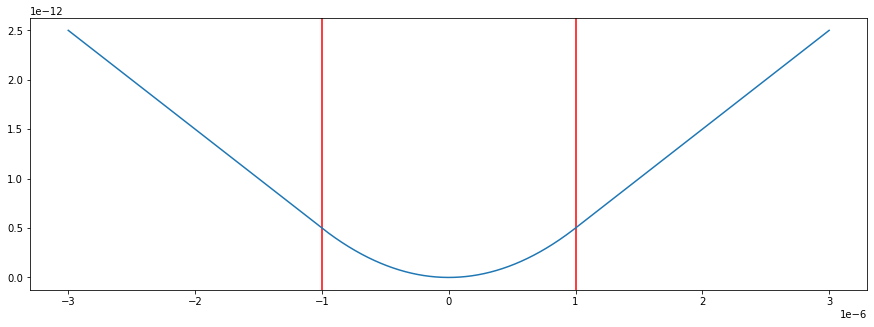

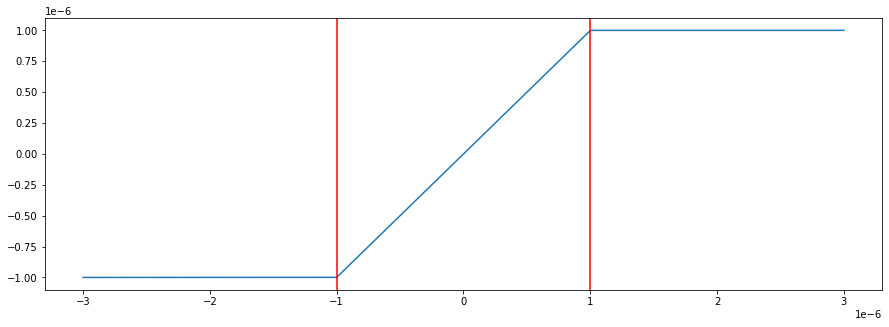

In [146]:
#check correct implementation of grad_huber
plt.figure(figsize=(15,5))
x = np.linspace(-3e-6,3e-6,100000)
y1 = huber(x)
y2 = grad_huber(x)
plt.axvline(1e-6,color="red")
plt.axvline(-1e-6,color="red")
plt.plot(x,y1)
plt.show()
plt.figure(figsize=(15,5))
plt.plot(x,y2)
plt.axvline(1e-6,color="red")
plt.axvline(-1e-6,color="red")
plt.show()

In [149]:
#gives us our beta from the lasso huber regression model using gradient descent using given lambda
def minimize_ls_huber(X, y, lambd, n_iters=100000, step_size=1e-3):
    #introduce the intercept term
    X_aug = np.concatenate((np.ones((X.shape[0],1)),X),axis=1)
    n, p = X_aug.shape
    XX = X_aug.T @ X_aug / n
    Xy = X_aug.T @ y / n
    # next line: initialise betas
    beta = np.zeros(p)
    # gradient descent
    for i in range(n_iters):
        #leave out the intercept term in the grad_huber function (same as ridge regression)
        grad = -2 * (Xy - XX @ beta) + lambd* np.concatenate((np.zeros((1)), grad_huber(beta[1:])))
       
        # next line: gradient descent update
        beta = beta - step_size * grad
    return beta

In [152]:
#we see for lam=0 we do not get the beta predictor from LS regression
#this is because gradient descent finds the local minimum based on the inital beta not global minimum like LS
print(minimize_ls_huber(stdXtrain,stdYtrain,0))
print(beta_ls)

[ 2.57196637e+00  5.76810433e-02  1.26340819e+00 -6.55406766e-02
  3.63705508e-01  5.88174008e-03  3.90152025e-01 -7.08369408e-02
 -3.48107805e-02 -1.47695600e-02  3.48026712e-04]
[ 2.61638041e+00  4.47138333e-02  1.25871884e+00 -3.80092766e-02
  3.63073448e-01  4.66534885e-03  3.90510052e-01 -7.46028629e-02
 -3.57069460e-02 -1.52588258e-02 -1.80315940e-03]


In [153]:
predict_with_estimate(stdXtest,minimize_ls_huber(stdXtrain,stdYtrain,0))

array([2.48980197, 5.65238241, 3.7489328 , ..., 4.30203065, 4.44801373,
       2.38840185])

In [155]:
predict_with_estimate(stdXtest,beta_ls)

array([2.4953788 , 5.65988436, 3.74511693, ..., 4.30643685, 4.45504931,
       2.40315046])

In [157]:
#get MSE of test set using ridge regression with given lambda
def lasso_MSE(xtrain,ytrain,xtest,ytest,lam):
    e = ytest - predict_with_estimate(xtest,minimize_ls_huber(xtrain,ytrain,lam))
    return 1/len(ytest) * np.dot(e,e)

In [158]:
#cross validate using precalculated fold indexes and given lambda on X,y set
def cross_validation_lasso(X,y,indexes,lam):
    MSEs = []
    for i in range(len(indexes)-1):
        #get indexes for validation set and the complement
        validindex = np.arange(indexes[i],indexes[i+1])
        invalidindex = list(set(range(len(y)))-set(validindex))
        #get validation set and complement
        vX = X[validindex]
        vy = y[validindex]
        nvX = X[invalidindex]
        nvy = y[invalidindex]
        #append MSE for current validation set using lasso MSE
        MSEs.append(lasso_MSE(nvX,nvy,vX,vy,lam))
    #return average MSE over all validation sets
    return np.mean(MSEs)

In [164]:
#loop over various lams and select lam with lowest mean MSE from cross validation
def get_best_lam_lasso(X,y,indexes,lamrange,show=False):
    meanMSEs = []
    for lam in lamrange:
        meanMSEs.append(cross_validation_lasso(X,y,indexes,lam))
    out = (lamrange[np.argmin(meanMSEs)],min(meanMSEs))
    if show:
        plt.figure(figsize=(15, 8))
        plt.scatter(lamrange,meanMSEs)
        plt.scatter(out[0],out[1],color='red',marker="x",label="Minimum")
        plt.xlabel("lambda")
        plt.ylabel("Mean MSE from cross validation")
        plt.title("Scan of penalty hyper-parameter to find its optimal value")
        plt.legend()
        plt.show()
    
    return out

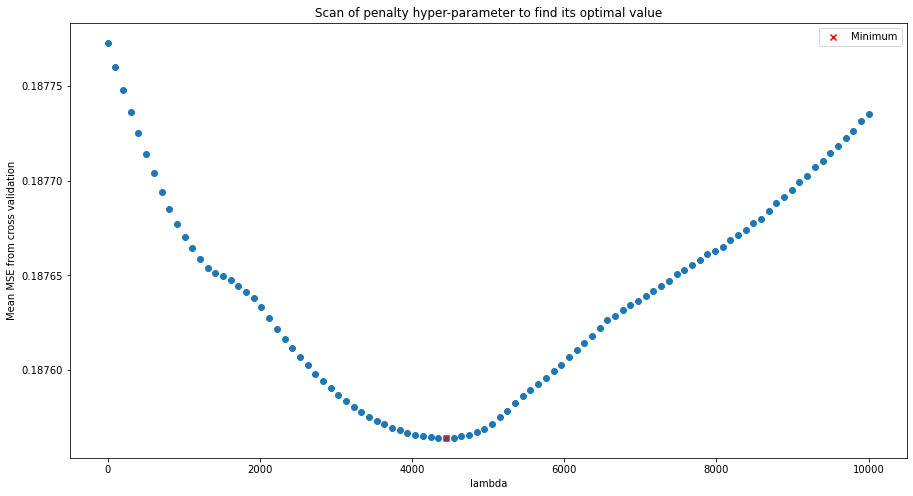

Time elapsed: 1762.0 s
4444.444444444444 0.18756421020911906


In [165]:
#first we get a general idea of which is the optimum lambda
start = time.time()
lasslambda, lasslambdaMSE = get_best_lam_lasso(stdXtrain,stdYtrain,get_fold_ind(stdYtrain,5),np.linspace(0,10000,100),show=True)
end = time.time()
print("Time elapsed:",np.round(end - start),"s")
print(lasslambda, lasslambdaMSE)

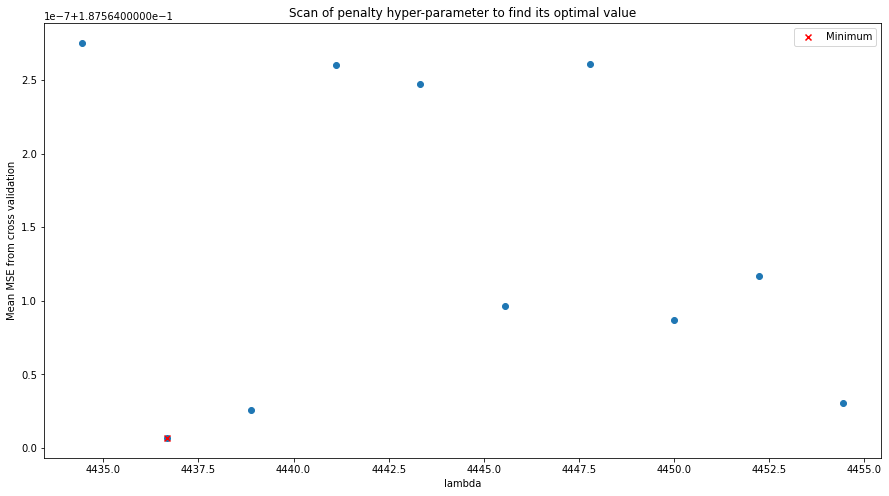

In [217]:
#we run again on refined interval near minimum of first scan
optlasslambda,optlasslambdaMSE = get_best_lam_lasso(stdXtrain,stdYtrain,get_fold_ind(stdYtrain,5),np.linspace(lasslambda-10,lasslambda+10,10),show=True)

In [218]:
print(optlasslambda,optlasslambdaMSE)
print("The optimum penalty is:",optlasslambda, "which gives a MSE of :",optlasslambdaMSE)

4436.666666666667 0.18756400681667482
The optimum penalty is: 4436.666666666667 which gives a MSE of : 0.18756400681667482


In [219]:
insamplersquaredlasso = Rsquared(stdXtrain,stdYtrain, beta_lasso_star)
print("In-sample R^2 score using ridge regression and 5 fold cross validation:", insamplersquaredlasso)

In-sample R^2 score using ridge regression and 5 fold cross validation: 0.8717514876624681


In [220]:
#calculate Out-of-sample R^2 score using prior built Rsquared function
outofsamplersquaredlasso = Rsquared(stdXtest,stdYtest,beta_lasso_star)
print("Out-of-sample R^2 score using ridge regression and 5 fold cross validation:", outofsamplersquaredlasso)

Out-of-sample R^2 score using ridge regression and 5 fold cross validation: 0.8640962352276129


In [221]:
print("In-sample R^2 score using ridge regression and 5 fold cross validation:", insamplersquaredlasso, ">", "Out-of-sample R^2 score using ridge regression and 5 fold cross validation:", outofsamplersquaredlasso)

In-sample R^2 score using ridge regression and 5 fold cross validation: 0.8717514876624681 > Out-of-sample R^2 score using ridge regression and 5 fold cross validation: 0.8640962352276129


We provide a comparison of the out-of-sample and in-sample $R^2$ scores for each model.

In [228]:
lassodata = [["","LASSO-HUBER","RIDGE","OLS"],["Out-of-sample R^2", outofsamplersquaredlasso,outofsamplersquaredridge,outofsamplersquared],["In-sample R^2",insamplersquaredlasso,insamplersquaredridge,insamplersquared]]
print(tabulate(lassodata,headers='firstrow',tablefmt='fancy_grid'))

╒═══════════════════╤═══════════════╤══════════╤══════════╕
│                   │   LASSO-HUBER │    RIDGE │      OLS │
╞═══════════════════╪═══════════════╪══════════╪══════════╡
│ Out-of-sample R^2 │      0.864096 │ 0.86429  │ 0.864293 │
├───────────────────┼───────────────┼──────────┼──────────┤
│ In-sample R^2     │      0.871751 │ 0.871826 │ 0.871826 │
╘═══════════════════╧═══════════════╧══════════╧══════════╛


We first display the regression coefficients for both lasso and ridge.

In [225]:
beta_lasso_star = minimize_ls_huber(stdXtrain,stdYtrain,optlasslambda)
col0 = np.concatenate((["Coefficient index"],range(11)))
col1 = np.concatenate((["LASSO-HUBER"],beta_lasso_star))
col2 = np.concatenate((["RIDGE"],beta_ridge_star))
col3 = np.concatenate((["OLS"],beta_ls))
data = np.array([col0,col1,col2,col3]).T
print(tabulate(data,headers='firstrow',tablefmt='fancy_grid'))

╒═════════════════════╤═══════════════╤══════════════╤═════════════╕
│   Coefficient index │   LASSO-HUBER │        RIDGE │         OLS │
╞═════════════════════╪═══════════════╪══════════════╪═════════════╡
│                   0 │   2.62536     │  2.6169      │  2.61638    │
├─────────────────────┼───────────────┼──────────────┼─────────────┤
│                   1 │   0.0207262   │  0.0446062   │  0.0447138  │
├─────────────────────┼───────────────┼──────────────┼─────────────┤
│                   2 │   1.24523     │  1.2569      │  1.25872    │
├─────────────────────┼───────────────┼──────────────┼─────────────┤
│                   3 │  -5.05667e-06 │ -0.0379505   │ -0.0380093  │
├─────────────────────┼───────────────┼──────────────┼─────────────┤
│                   4 │   0.359028    │  0.362995    │  0.363073   │
├─────────────────────┼───────────────┼──────────────┼─────────────┤
│                   5 │   5.32241e-07 │  0.00474696  │  0.00466535 │
├─────────────────────┼───────────

When comparing lasso-huber and ridge we observe that for all but coefficients 3, 5 and 10 we have very similar results. But at 3, 5 and 10 we see that lasso-huber has shrunk the magnitude of the coefficients to near absolute zero. The reason for this lies in the lasso huber function itself and the fact that we fix $c=0.001$ to be small. $$L_{c }(\beta)={\begin{cases}{\frac  {1}{2}}{\beta^{2}}&{\text{for }}|\beta|\leq c ,\\c (|\beta|-{\frac  {1}{2}}c ),&{\text{otherwise.}}\end{cases}}$$
$$\Rightarrow \frac{d L_{c }(\beta)}{d \beta}={\begin{cases}{}{\beta}&{\text{for }}|\beta|\leq c ,\\c \frac{\beta}{|\beta|},&{\text{otherwise.}}\end{cases}}$$
For small coefficients of $\beta$ ($\leq 0.001$), the huber function is equivalent to the usual L2 least squares penalty function, and for large coefficients it is equivalent to the standard noise insensitive, robust, L1 penalty function.  In other words, the residuals are penalized by their square when they are small (L2) and by their absolute value when they are large (L1).
During gradient descent we iteratively update our $\beta$.  Since in gradient descent the step size is small (default 1e-3) we do not need to worry about components jumping between the L2 and L1 range portions of the huber function. So the components initially in the L2 range will be evaluated in the same way ridge components are and components in the L1 range will be evaluated in the way that pure lasso components are. In each iteration we are applying the derivative of the huber function to all of the regression coefficients bar the intercept term, hence why we see all 3 methods have the same intercept. We see that if a $\beta$ coefficient has magnitude greater than c then it will be scaled by its absolute value and hence reduced to 0 very quickly. This is known as feature selection, where coefficients of features with poor predictability (large noise) will be forced quickly to zero. This means that the some independent variables are removed from the model introducing sparsity. Ultimately, lasso-huber regression is almost equal to the customary ridge regression L2 approach, but it adapts itself to a moderate number of large noise values.

<a name="task-2"></a>

# Task 2: Classification [^](#outline)

<a name="q21"></a>

## 2.1 [^](#outline)

The concept of kNN classification is as follows: an input to the model is classified by a plurality vote of its neighbours in the train data; in other words, the input is given the same class as the majority of the nearest k neighbours. Here, nearest can be defined with any metric but most often we use Euclidean distance. If k = 1, then the input is simply assigned to the class of that single nearest neighbour.

In [240]:
# load train data as pandas data frames
tum_samples = pd.read_csv('tumour_samples.csv')
tum_samples

,Unnamed: 0,n1_radius,n1_texture,n1_perimeter,n1_area,n1_smoothness,n1_compactness,n1_concavity,n1_concave_points,n1_symmetry,...,n3_texture,n3_perimeter,n3_area,n3_smoothness,n3_compactness,n3_concavity,n3_concave_points,n3_symmetry,n3_fractal_dimension,DIAGNOSIS
0,0,10.855170,15.248290,69.167041,359.534878,0.105488,0.080200,0.066410,0.034194,0.182796,...,18.984557,81.443134,466.879302,0.149080,0.200185,0.205695,0.111592,0.335999,0.093477,B
1,1,10.068958,15.532758,66.130635,330.040665,0.099813,0.109540,0.057583,0.023322,0.195650,...,22.840293,82.133171,473.367822,0.125478,0.330466,0.283304,0.088021,0.312882,0.096158,B
2,2,12.271409,18.100314,78.195610,421.537832,0.105147,0.095315,0.043317,0.031539,0.188801,...,26.365608,84.598334,620.586067,0.146766,0.118707,0.147900,0.050402,0.291805,0.069556,B
3,3,10.531733,18.452486,67.227069,340.063033,0.086041,0.049961,0.049709,0.011046,0.203093,...,24.385385,73.296855,429.675600,0.100060,0.143683,0.177225,0.028111,0.287749,0.073174,B
4,4,12.367686,14.399191,80.643814,460.849710,0.106410,0.101420,0.020806,0.021990,0.195326,...,19.614305,89.910502,472.323112,0.138135,0.276127,0.151098,0.074396,0.345258,0.095830,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2561,2561,14.383173,19.454910,100.495126,637.413375,0.076174,0.224136,0.305786,0.073760,0.168884,...,23.016513,108.867289,731.638144,0.079317,0.410666,0.674672,0.146962,0.241495,0.106978,B
2562,2562,10.018359,18.661516,61.848450,291.512307,0.083671,0.048121,0.028997,0.007389,0.164375,...,24.919767,67.920361,374.629250,0.129882,0.081497,0.109356,0.028243,0.252432,0.081462,B
2563,2563,11.168036,12.651203,67.102303,376.640056,0.096154,0.050181,0.017739,0.022895,0.183905,...,17.412221,73.221040,421.681446,0.135757,0.089036,0.070456,0.039851,0.295527,0.070584,B
2564,2564,11.719646,18.933783,78.556817,426.631397,0.113492,0.091756,0.070046,0.039025,0.203736,...,26.677691,86.572055,539.508865,0.132254,0.194688,0.179610,0.071053,0.330223,0.079510,B


In [241]:
#removed extra index column and convert DIAGNOSIS to boolean
tum_samples.drop(tum_samples.columns[0], axis=1, inplace=True)
tum_samples["DIAGNOSIS"] = (tum_samples["DIAGNOSIS"] == "M").astype("int") #M is 1 and B is 0
tum_samples

,n1_radius,n1_texture,n1_perimeter,n1_area,n1_smoothness,n1_compactness,n1_concavity,n1_concave_points,n1_symmetry,n1_fractal_dimension,...,n3_texture,n3_perimeter,n3_area,n3_smoothness,n3_compactness,n3_concavity,n3_concave_points,n3_symmetry,n3_fractal_dimension,DIAGNOSIS
0,10.855170,15.248290,69.167041,359.534878,0.105488,0.080200,0.066410,0.034194,0.182796,0.066968,...,18.984557,81.443134,466.879302,0.149080,0.200185,0.205695,0.111592,0.335999,0.093477,0
1,10.068958,15.532758,66.130635,330.040665,0.099813,0.109540,0.057583,0.023322,0.195650,0.069572,...,22.840293,82.133171,473.367822,0.125478,0.330466,0.283304,0.088021,0.312882,0.096158,0
2,12.271409,18.100314,78.195610,421.537832,0.105147,0.095315,0.043317,0.031539,0.188801,0.063341,...,26.365608,84.598334,620.586067,0.146766,0.118707,0.147900,0.050402,0.291805,0.069556,0
3,10.531733,18.452486,67.227069,340.063033,0.086041,0.049961,0.049709,0.011046,0.203093,0.064948,...,24.385385,73.296855,429.675600,0.100060,0.143683,0.177225,0.028111,0.287749,0.073174,0
4,12.367686,14.399191,80.643814,460.849710,0.106410,0.101420,0.020806,0.021990,0.195326,0.064605,...,19.614305,89.910502,472.323112,0.138135,0.276127,0.151098,0.074396,0.345258,0.095830,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2561,14.383173,19.454910,100.495126,637.413375,0.076174,0.224136,0.305786,0.073760,0.168884,0.076114,...,23.016513,108.867289,731.638144,0.079317,0.410666,0.674672,0.146962,0.241495,0.106978,0
2562,10.018359,18.661516,61.848450,291.512307,0.083671,0.048121,0.028997,0.007389,0.164375,0.061095,...,24.919767,67.920361,374.629250,0.129882,0.081497,0.109356,0.028243,0.252432,0.081462,0
2563,11.168036,12.651203,67.102303,376.640056,0.096154,0.050181,0.017739,0.022895,0.183905,0.061150,...,17.412221,73.221040,421.681446,0.135757,0.089036,0.070456,0.039851,0.295527,0.070584,0
2564,11.719646,18.933783,78.556817,426.631397,0.113492,0.091756,0.070046,0.039025,0.203736,0.066225,...,26.677691,86.572055,539.508865,0.132254,0.194688,0.179610,0.071053,0.330223,0.079510,0


In [242]:
#check if data cleaning is needed
#we see there are no duplicated rows
print(np.array_equal(tum_samples.duplicated(),[False]*len(tum_samples)))

True


In [243]:
# load test data as pandas data frames (WE DO NOT USE THIS IN OUR MODEL TRAINING AT ANY POINT)
tum_test = pd.read_csv('tumour_test.csv')
tum_test

,Unnamed: 0,n1_radius,n1_texture,n1_perimeter,n1_area,n1_smoothness,n1_compactness,n1_concavity,n1_concave_points,n1_symmetry,...,n3_texture,n3_perimeter,n3_area,n3_smoothness,n3_compactness,n3_concavity,n3_concave_points,n3_symmetry,n3_fractal_dimension,DIAGNOSIS
0,0,13.40,20.52,88.64,556.7,0.11060,0.14690,0.14450,0.08172,0.2116,...,29.66,113.30,844.4,0.15740,0.38560,0.51060,0.20510,0.3585,0.11090,M
1,1,13.21,25.25,84.10,537.9,0.08791,0.05205,0.02772,0.02068,0.1619,...,34.23,91.29,632.9,0.12890,0.10630,0.13900,0.06005,0.2444,0.06788,B
2,2,14.02,15.66,89.59,606.5,0.07966,0.05581,0.02087,0.02652,0.1589,...,19.31,96.53,688.9,0.10340,0.10170,0.06260,0.08216,0.2136,0.06710,B
3,3,14.26,18.17,91.22,633.1,0.06576,0.05220,0.02475,0.01374,0.1635,...,25.26,105.80,819.7,0.09445,0.21670,0.15650,0.07530,0.2636,0.07676,B
4,4,13.03,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.02923,0.1467,...,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169,B
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,195,19.73,19.82,130.70,1206.0,0.10620,0.18490,0.24170,0.09740,0.1733,...,25.59,159.80,1933.0,0.17100,0.59550,0.84890,0.25070,0.2749,0.12970,M
196,196,23.29,26.67,158.90,1685.0,0.11410,0.20840,0.35230,0.16200,0.2200,...,32.68,177.00,1986.0,0.15360,0.41670,0.78920,0.27330,0.3198,0.08762,M
197,197,13.20,17.43,84.13,541.6,0.07215,0.04524,0.04336,0.01105,0.1487,...,27.82,88.28,602.0,0.11010,0.15080,0.22980,0.04970,0.2767,0.07198,B
198,198,13.64,15.60,87.38,575.3,0.09423,0.06630,0.04705,0.03731,0.1717,...,19.05,94.11,683.4,0.12780,0.12910,0.15330,0.09222,0.2530,0.06510,B


In [244]:
#removed extra index column and convert DIAGNOSIS to boolean
tum_test.drop(tum_test.columns[0], axis=1, inplace=True)
tum_test["DIAGNOSIS"] = (tum_test["DIAGNOSIS"] == "M").astype("int")



In [245]:
tum_test

,n1_radius,n1_texture,n1_perimeter,n1_area,n1_smoothness,n1_compactness,n1_concavity,n1_concave_points,n1_symmetry,n1_fractal_dimension,...,n3_texture,n3_perimeter,n3_area,n3_smoothness,n3_compactness,n3_concavity,n3_concave_points,n3_symmetry,n3_fractal_dimension,DIAGNOSIS
0,13.40,20.52,88.64,556.7,0.11060,0.14690,0.14450,0.08172,0.2116,0.07325,...,29.66,113.30,844.4,0.15740,0.38560,0.51060,0.20510,0.3585,0.11090,1
1,13.21,25.25,84.10,537.9,0.08791,0.05205,0.02772,0.02068,0.1619,0.05584,...,34.23,91.29,632.9,0.12890,0.10630,0.13900,0.06005,0.2444,0.06788,0
2,14.02,15.66,89.59,606.5,0.07966,0.05581,0.02087,0.02652,0.1589,0.05586,...,19.31,96.53,688.9,0.10340,0.10170,0.06260,0.08216,0.2136,0.06710,0
3,14.26,18.17,91.22,633.1,0.06576,0.05220,0.02475,0.01374,0.1635,0.05586,...,25.26,105.80,819.7,0.09445,0.21670,0.15650,0.07530,0.2636,0.07676,0
4,13.03,18.42,82.61,523.8,0.08983,0.03766,0.02562,0.02923,0.1467,0.05863,...,22.81,84.46,545.9,0.09701,0.04619,0.04833,0.05013,0.1987,0.06169,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,19.73,19.82,130.70,1206.0,0.10620,0.18490,0.24170,0.09740,0.1733,0.06697,...,25.59,159.80,1933.0,0.17100,0.59550,0.84890,0.25070,0.2749,0.12970,1
196,23.29,26.67,158.90,1685.0,0.11410,0.20840,0.35230,0.16200,0.2200,0.06229,...,32.68,177.00,1986.0,0.15360,0.41670,0.78920,0.27330,0.3198,0.08762,1
197,13.20,17.43,84.13,541.6,0.07215,0.04524,0.04336,0.01105,0.1487,0.05635,...,27.82,88.28,602.0,0.11010,0.15080,0.22980,0.04970,0.2767,0.07198,0
198,13.64,15.60,87.38,575.3,0.09423,0.06630,0.04705,0.03731,0.1717,0.05660,...,19.05,94.11,683.4,0.12780,0.12910,0.15330,0.09222,0.2530,0.06510,0


Just like in the first question we see many features are correlated (obvious since we have clearly related quantitites such as radius and area) and again for the same reasons as outlined in the first question introduction we do not feature drop in this question.

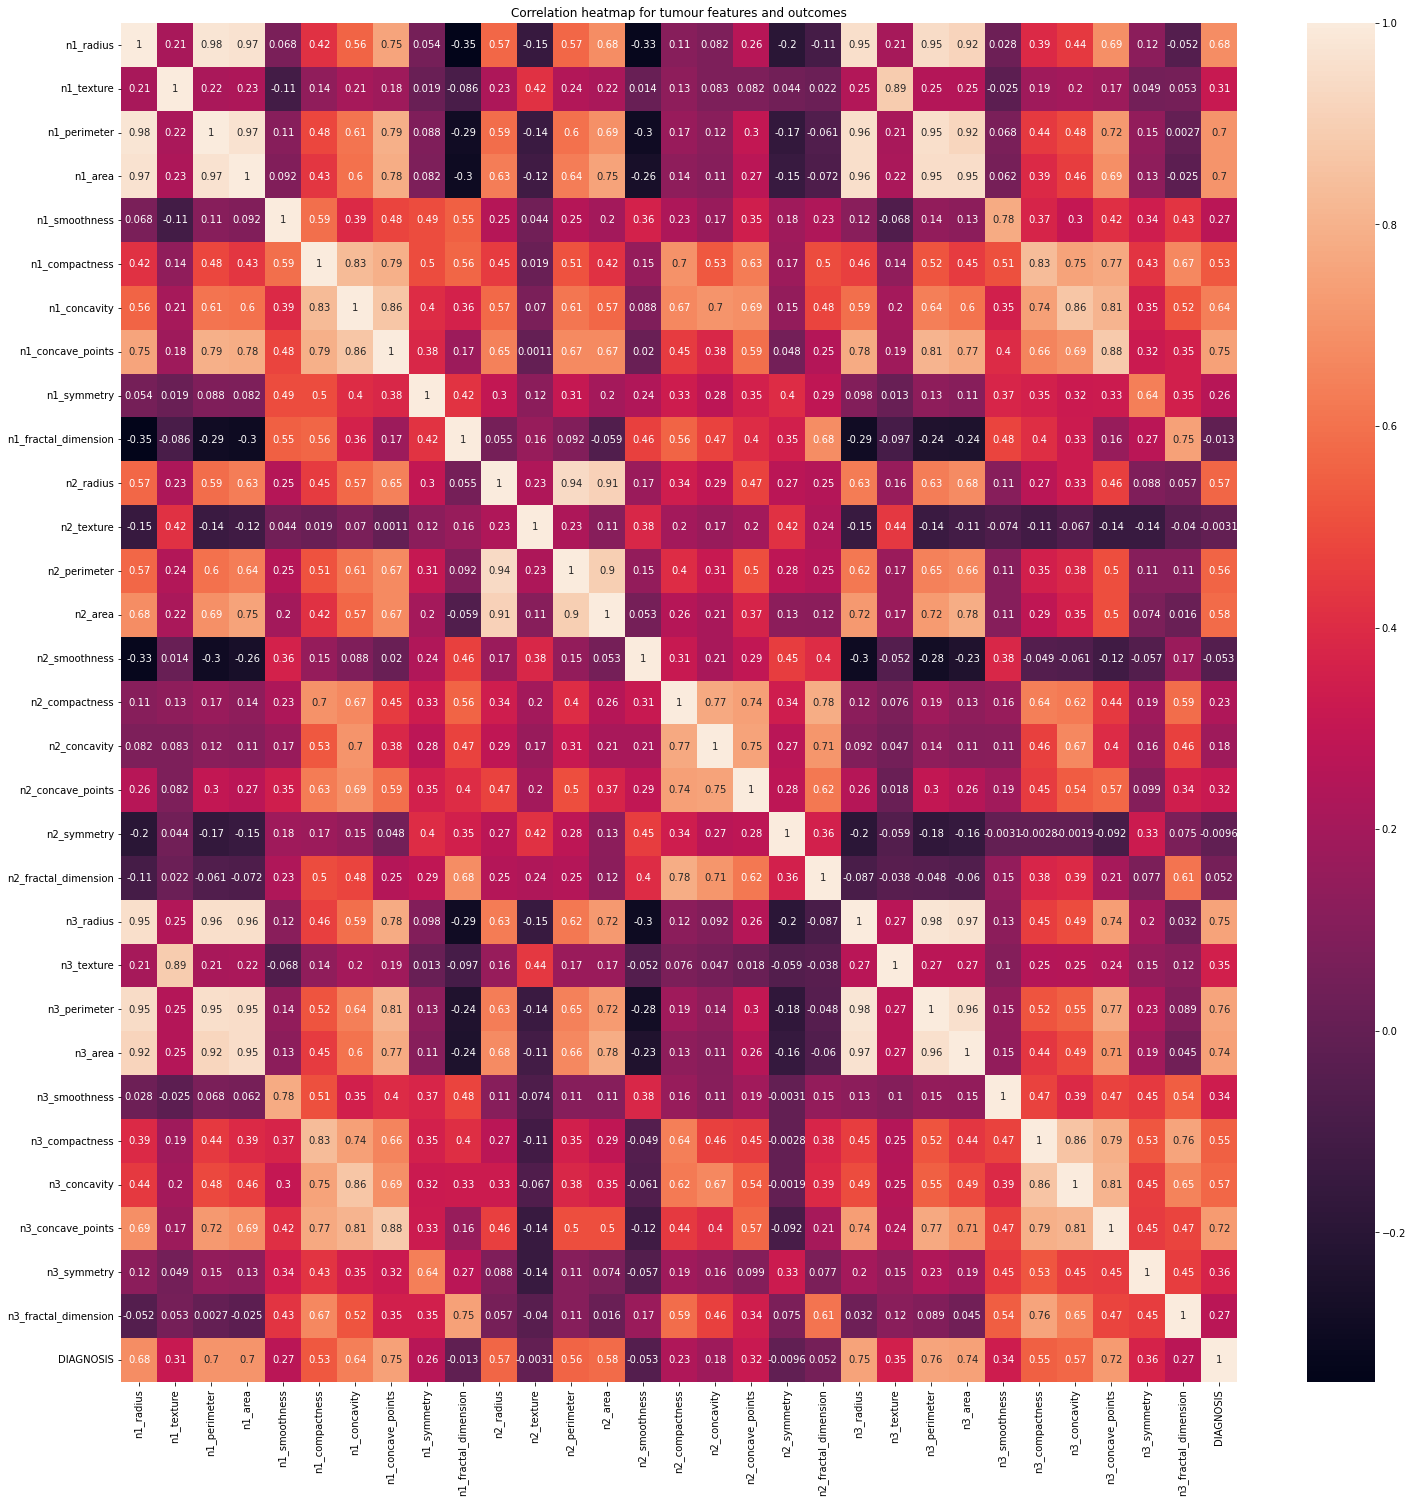

In [340]:
#correlations
plt.figure(figsize = (25,25))
corrMatrix = tum_samples.corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation heatmap for tumour features and outcomes")
plt.show()

In [246]:
#check if data cleaning is needed
#we see there are no duplicated rows
print(np.array_equal(tum_test.duplicated(),[False]*len(tum_test)))

True


In [247]:
#formating data into training data X and y
X_train = tum_samples.to_numpy()[:,:-1]
y_train = tum_samples.to_numpy(dtype="int")[:,-1]

In [248]:
#formating data into test data X and y
X_test = tum_test.to_numpy()[:,:-1]
y_test = tum_test.to_numpy(dtype="int")[:,-1]

We implement the Euclidean distance $d$, defined as
$$
d(\boldsymbol p, \boldsymbol q) = \sqrt{\sum_{i=1}^D{(q_i-p_i)^2}} \, ,
$$
where $\boldsymbol p$ and $\boldsymbol q$ are the two points in our $D$-dimensional Euclidean space.

In [249]:
def euclidian_distance(p, q):
    return np.abs(np.sum((p-q)**2, axis=1))**2

It is very important to feature standardisation in the pre-proccessing step of kNN. This is since the distance calculation done in KNN uses feature values. If one feature unit measurement is greater than another that feature will dominate the distance hence the outcome of the KNN. Hence, we must have all features with the same scale before we apply the model.

In [252]:
X_, params = standardise(X_train)
params

[(13.029682392637344, 2.885421570078412),
 (18.548664811862476, 4.22072853467413),
 (84.2339194645434, 19.92425042740272),
 (548.7199711696599, 273.7083784142111),
 (0.09423882566555124, 0.014144282544403778),
 (0.09058029846704904, 0.045295210411123),
 (0.06530809789198029, 0.06558411328165681),
 (0.03593102074900124, 0.030769066551462394),
 (0.17732762818975395, 0.026580098655306087),
 (0.0628015327672954, 0.007014863054428375),
 (0.3383011880231716, 0.21577924584328906),
 (1.2184126237799537, 0.5818262548319622),
 (2.386005208494565, 1.540869913698305),
 (29.624647572789513, 32.9859763195599),
 (0.007145871381117571, 0.003112055841401645),
 (0.02322513963013712, 0.017273295667903796),
 (0.02898798863784462, 0.031929861158632604),
 (0.010750100754357068, 0.006061383675482077),
 (0.020581384456676826, 0.007693145794934629),
 (0.0036920617331611437, 0.0028742885371232795),
 (14.663288407071176, 3.849670644824343),
 (24.467744660150267, 5.976673616434785),
 (95.93026907112662, 26.703945

In [253]:
#we see standardisation works as planned
X__, params = standardise(X_)
params

[(-1.107627023788153e-17, 0.9999999999999999),
 (8.47334673197937e-16, 1.0),
 (4.0151479612320546e-17, 0.9999999999999999),
 (1.6891312112769335e-16, 1.0),
 (1.118011027136167e-16, 1.0),
 (9.69173645814634e-18, 1.0),
 (-1.3395364318937975e-16, 1.0),
 (-2.7690675594703826e-17, 1.0),
 (7.061122276649476e-17, 1.0),
 (-9.27637632422578e-16, 1.0),
 (-3.876694583258536e-17, 1.0),
 (2.436779452333937e-16, 1.0),
 (-1.0799363481934493e-16, 1.0),
 (-4.153601339205574e-17, 1.0),
 (-2.215254047576306e-17, 1.0),
 (-1.3845337797351913e-17, 1.0),
 (1.938347291629268e-17, 0.9999999999999999),
 (-9.830189836119858e-17, 1.0),
 (-8.307202678411148e-18, 1.0),
 (8.999469568278744e-17, 0.9999999999999999),
 (-1.8275845892504524e-16, 1.0),
 (-2.395243438941881e-16, 1.0),
 (-3.3228810713644594e-17, 1.0),
 (1.0799363481934493e-16, 1.0),
 (6.064257955240138e-16, 1.0),
 (-6.9226688986759565e-18, 1.0),
 (1.5610618366514283e-16, 1.0),
 (-8.584109434358186e-17, 0.9999999999999999),
 (-3.945921272245295e-16, 1.0),
 

In [261]:
#first randomly permute our train data in case it was entered in some ordered way
np.random.seed(10)
p = np.random.permutation(len(y_train))
X_train = X_train[p]
y_train = y_train[p]

In [265]:
#input unstandardised data and we standardize first thing in the function
def k_neighbours(X_train, X_test, k=5, return_distance=False):
    n_neighbours = k
    dist = []
    neigh_ind = []
    #standardise the data
    Xtrainstd, xparams = standardise(X_train)
    #shift testing data by same parameters for each column
    Xteststd = 1.0 * X_test
    for i in range(X_test.shape[1]):
        mu, std = xparams[i]
        Xteststd[:,i] = (Xteststd[:,i]-mu)/std
    # compute distance from each point x_test in X_teststd to all points in X_trainstd
    point_dist = [euclidian_distance(x_test, Xtrainstd) for x_test in Xteststd]

    # determine which k training points are closest to each test point
    for row in point_dist:
        enum_neigh = enumerate(row)
        sorted_neigh = sorted(enum_neigh, key=lambda x: x[1])[:k]

        ind_list = [tup[0] for tup in sorted_neigh]
        dist_list = [tup[1] for tup in sorted_neigh]

        dist.append(dist_list)
        neigh_ind.append(ind_list)
  
    # return distances together with indices of k nearest neighbours
    if return_distance:
        return np.array(dist), np.array(neigh_ind)
  
    return np.array(neigh_ind)

In [266]:
#predict class of test data using kNN
def predict(X_train, y_train, X_test, k=5):
    # each of the k neighbours contributes equally to the classification of any data point in X_test  
    neighbours = k_neighbours(X_train, X_test, k=k)
    # count number of occurences of label with np.bincount and choose the label that has most with np.argmax
    y_pred = np.array([np.argmax(np.bincount(y_train[neighbour])) for neighbour in neighbours])

    return y_pred

In [291]:
#returns accuracy score for test class predictions using true test classes
def score(X_train, y_train, X_test, y_test, k=5):
    y_pred = predict(X_train, y_train, X_test, k=k)
    return float(sum(y_pred==y_test))/ float(len(y_test))

In [292]:
#test in sample accuracy with k=4 
k = 4
print('Train set mean accuracy:', score(X_train, y_train, X_train, y_train, k=k))

Train set mean accuracy: 0.9863600935307872


In [293]:
#test out of sample accuracy with k=4 
k = 4
print('Test set mean accuracy:', score(X_train, y_train, X_test, y_test, k=k))

Test set mean accuracy: 0.975


As expected we see the in sample accuracy is higher than out of sample accuracy since in predicting the classification of the train data we use the distances in the train data itself so for k = 1 this is actually just the point itself and we should obtain 100% accuracy.

In [294]:
#test in sample accuracy with k=1
k = 1
print('Train set mean accuracy:', score(X_train, y_train, X_train, y_train, k=k))

Train set mean accuracy: 1.0


In [287]:
#middle fold has extra sample in
inds = get_fold_ind(y_train,5)
inds

[0, 513, 1026, 1540, 2053, 2566]

In [309]:
#cross validating for fixed number of neighbours
def cross_validation_score(X_train, y_train, folds, k, demonstrate=False):
    scores = []
    for i in range(len(folds)-1):
        #create indexes for validation set and its complement
        val_indexes = np.arange(folds[i],folds[i+1])
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))
        #obtain validation set and its complement
        X_train_i = X_train[train_indexes, :]
        y_train_i = y_train[train_indexes]
        X_val_i = X_train[val_indexes, :]
        y_val_i = y_train[val_indexes]
        #append the accuracy score for current validation fold
        if demonstrate
        score_i = score(X_train_i, y_train_i, X_val_i, y_val_i, k=k)
        scores.append(score_i)
        if demonstrate:
            print("Fold:",i)
            print("Validation set is:\n",val_indexes)
            print("Accuracy score for current validation fold:",score_i)
    if demonstrate:
        print("----------------")
        print("Average score:",sum(scores) / len(scores))
    # Return the average score
    return sum(scores) / len(scores)

In [315]:
#demonstrate cross validation for 5 folds and nearest 3 neighbours
cross_validation_score(X_train, y_train, inds, k=3, demonstrate=True)

Fold: 0
Validation set is:
 [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 23

Fold: 4
Validation set is:
 [2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064 2065 2066
 2067 2068 2069 2070 2071 2072 2073 2074 2075 2076 2077 2078 2079 2080
 2081 2082 2083 2084 2085 2086 2087 2088 2089 2090 2091 2092 2093 2094
 2095 2096 2097 2098 2099 2100 2101 2102 2103 2104 2105 2106 2107 2108
 2109 2110 2111 2112 2113 2114 2115 2116 2117 2118 2119 2120 2121 2122
 2123 2124 2125 2126 2127 2128 2129 2130 2131 2132 2133 2134 2135 2136
 2137 2138 2139 2140 2141 2142 2143 2144 2145 2146 2147 2148 2149 2150
 2151 2152 2153 2154 2155 2156 2157 2158 2159 2160 2161 2162 2163 2164
 2165 2166 2167 2168 2169 2170 2171 2172 2173 2174 2175 2176 2177 2178
 2179 2180 2181 2182 2183 2184 2185 2186 2187 2188 2189 2190 2191 2192
 2193 2194 2195 2196 2197 2198 2199 2200 2201 2202 2203 2204 2205 2206
 2207 2208 2209 2210 2211 2212 2213 2214 2215 2216 2217 2218 2219 2220
 2221 2222 2223 2224 2225 2226 2227 2228 2229 2230 2231 2232 2233 2234
 2235 2236 2237 2238 2239 2240 2241 2242 2243 224

0.9836325573986848

In [296]:
def choose_best_k(X_train, y_train, folds, k_range):
    k_scores = np.zeros((len(k_range),))
  
    for i, k in enumerate(k_range):
        k_scores[i] = cross_validation_score(X_train, y_train, folds, k)
        print(f'CV_ACC@k={k}: {k_scores[i]:.3f}')

    best_k_index = np.argmax(k_scores)
    return k_range[best_k_index]

In [297]:
best_k = choose_best_k(X_train, y_train, inds, np.arange(1, 21))

print('best_k:', best_k)

CV_ACC@k=1: 0.997
CV_ACC@k=2: 0.982
CV_ACC@k=3: 0.984
CV_ACC@k=4: 0.978
CV_ACC@k=5: 0.982
CV_ACC@k=6: 0.979
CV_ACC@k=7: 0.981
CV_ACC@k=8: 0.977
CV_ACC@k=9: 0.980
CV_ACC@k=10: 0.977
CV_ACC@k=11: 0.980
CV_ACC@k=12: 0.978
CV_ACC@k=13: 0.980
CV_ACC@k=14: 0.976
CV_ACC@k=15: 0.978
CV_ACC@k=16: 0.976
CV_ACC@k=17: 0.977
CV_ACC@k=18: 0.975
CV_ACC@k=19: 0.976
CV_ACC@k=20: 0.973
best_k: 1


It may seem at first that k=1 may be methodologically invalid based on the the fact that if we model on the train data itself we will always get 100% accruacy with k=1 and so 1 will always be the optimized number of neighbours. However, in cross validation we are splitting the data into validation and training sets and so we never train on the train set itself within the cross validation system. This can actually be seen since the cross validation mean score accuracy for k=1 does not equal 1. Hence, k=1 is methodologically valid.

We retrain the model on the train data using the best number of nearest neighbours, which we found to be 1. Then we find the score accuracy for predicting the test data classes using the nearest neighbour in the train set (k=1).

In [317]:
print('Train set mean accuracy:', score(X_train, y_train, X_train, y_train, k=best_k))
print('Test set mean accuracy:', score(X_train, y_train, X_test, y_test, k=best_k))

Train set mean accuracy: 1.0
Test set mean accuracy: 1.0


As explained above for k=1 when running the model on the train data itself the closest point is that same point in the training data so we will always obatain 100% accuracy there. For the test data we also obtain 100% score accuracy which means for any point in the test data the nearest point in the training data has the same class as it. So the performance of my optimised classifier on the data set tumour_samples.csv is equal to the performance on the test data set tumour_test.csv.

<a name="q22"></a>

## 2.2 [^](#outline)

First we mention why we do not feature standardise in this model. The Random Forest model is tree-based and hence does not require feature scaling since we are using partitioning based on cross-entropy/gini-coefficient/information-gain which inherently will not be affected by scaling.

We begin by developing the framework for a decision tree and then build up to a random forest.

In [345]:
#we will use equal weightings
training_weights = np.ones_like(y_train) / len(y_train)
# We need a dictionary indicating whether the column index maps to a 
# categorical feature or numerical
# In this data, all features are numerical (categorical=False)
columns_dict = {index: False for index in range(X_train.shape[1])}

In our lectures, we have learnt that:

- Decision tree algorithm is a _greedy algorithm_ that splits the data samples $\boldsymbol y$ into _left_ $\boldsymbol y_l$ and _right_ $\boldsymbol y_r$ samples, and the splitting is applied recursively on each side, resulting in a binary-tree like of splittings.
- Samples can be split given two parameters: the feature index $j$ and a value $s$.
  - **If the feature is a continuous variable**, the $s$ is used as a threshold such that samples with feature value less than $s$ are assigned to the left, and vice versa.
  - **if the feature is a categorical variable**, the $s$ is used as a predicate such that samples with feature value equals to $s$ are assigned to left, and vice versa.
- To determine $j$ and $s$ at each split node, we may use _CE-index_ to search for $j$ and $s$ that minimizes the weighted sum of _CE-index_ of the left side samples and right side samples:
  
  $$CE(\boldsymbol y; j, s) = p_l \times CE(\boldsymbol y_l) + p_r \times CE(\boldsymbol y_r)$$

where $p_l$ and $p_r$ are, respectively, the cumulative weights of samples on the left and on the right, while $CE(\boldsymbol y)$ is defined as:

$$
\text{CE}(\boldsymbol y) = - \sum_{i=1}^Q \mathbb P (y = c_i) \text{log}(\mathbb P (y = c_i))
$$

where $c_i$ is the i-th class out of $Q$ distinct classes, so $\mathbb P (y = c_i)$ reads the weight of the class $i$ in the current sample $\boldsymbol y$.

In [346]:
def ce_index(y, sample_weights):
    """ 
    Calculate the cross-entropy-index for labels.
    Arguments:
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
    Returns:
      (float): the CE-index for y.
    """

    # count different labels in y，and store in label_weights
    # initialize with zero for each distinct label.
    label_weights = {yi: 0 for yi in set(y)}  
    for yi, wi in zip(y, sample_weights):
        label_weights[yi] += wi

    total_weight = sum(label_weights.values())
    ce = 0
    for label, weight in label_weights.items():
        ce -= (weight / total_weight) * np.log(weight/ total_weight)

    return ce

In [347]:
# evaluate labels y
ce_index(y_train, training_weights)

0.4482540468603776

Next, we define a function to split the data samples based on a feature (column) index and a value. We will call it in later functions, e.g., in the next cell in `ce_split_value`.

In [348]:
def split_samples(X, y, sample_weights, column, value, categorical):
    """
    Return the split of data whose column-th feature:
    1. equals value, in case `column` is categorical, or
    2. less than value, in case `column` is not categorical (i.e. numerical)

    Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      column: the column of the feature for splitting.
      value: splitting threshold  the samples 
      categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
      tuple(np.array, np.array): tuple of subsets of X splitted based on column-th value.
      tuple(np.array, np.array): tuple of subsets of y splitted based on column-th value.
      tuple(np.array, np.array): tuple of subsets of sample weights based on column-th value.
    """ 

    if categorical:
        left_mask =(X[:, column] == value)
    else:
        left_mask = (X[:, column] < value)
  
    X_left, X_right = X[left_mask, :], X[~left_mask, :]
    y_left, y_right = y[left_mask], y[~left_mask]
    w_left, w_right  = sample_weights[left_mask], sample_weights[~left_mask]

    return (X_left, X_right), (y_left, y_right), (w_left, w_right)

For a given feature index, we need to estimate the best value $s$ to use as threshold (for numerical variables) or predicate (for categorical variables). We need to implement the function the searches for $s$ that minimizes the _CE-index_. Let's do this in the following cell by calling our previously defined two functions `split_samples` and `ce_index`. 

In [349]:
def ce_split_value(X, y, sample_weights, column, categorical):
    """
    Calculate the ce-index based on `column` with the split that minimizes the ce-index.
    Arguments:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      column: the column of the feature for calculating. 0 <= column < D
      categorical: boolean value indicating whether column is a categorical variable or numerical.
    Returns:
      (float, float): the resulted ce-index and the corresponding value used in splitting.
    """

    unique_vals = np.unique(X[:, column])

    assert len(unique_vals) > 1, f"There must be more than one distinct feature value. Given: {unique_vals}."

    ce_index_val, threshold = np.inf, None
  
    # split the values of i-th feature and calculate the cost 
    for value in unique_vals:
        (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, column, value, categorical)

        # if one of the two sides is empty, skip this split.
        if len(y_l) == 0 or len(y_r) == 0:
            continue
    
        p_left = sum(w_l)/(sum(w_l) + sum(w_r))
        p_right = 1 - p_left
        new_cost = p_left * ce_index(y_l, w_l) + p_right * ce_index(y_r, w_r)
        if new_cost < ce_index_val:
            ce_index_val, threshold = new_cost, value
    
    return ce_index_val, threshold

In [355]:
# evaluate for feature n1 perimeter
ce_split_value(X_train, y_train, training_weights, 2, columns_dict[2])

(0.22913904990185746, 101.08353373124535)

It's now time to choose the best feature to split by calling the function `ce_split_value` for each feature.

In [356]:
def ce_split(X, y, sample_weights, columns_dict):
    """
    Choose the best feature to split according to criterion.
    Args:
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
      (int, float): the best feature index and value used in splitting. 
      If the feature index is None, then no valid split for the current Node.
    """

    #initialize `split_column` to None, so if None returned this means there is no valid split at the current node.
    min_ce_index, split_column, split_val = np.inf, None, 0
    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue
        ce_index, val = ce_split_value(X, y, sample_weights, column, categorical)  
        if ce_index < min_ce_index:
            min_ce_index, split_column, split_val = ce_index, column, val

    return split_column, split_val

In [421]:
# evaluate which feature is best
a, b = ce_split(X_train, y_train, training_weights, columns_dict)
print((a, b))
print(tum_samples.iloc[:,a])

(22, 117.3317394573687)
0        81.443134
1        82.133171
2        84.598334
3        73.296855
4        89.910502
           ...    
2561    108.867289
2562     67.920361
2563     73.221040
2564     86.572055
2565     82.313581
Name: n3_perimeter, Length: 2566, dtype: float64


Now, we need a function that returns the label which appears the most in our label variable `y`.

In [359]:
def majority_vote(y, sample_weights):
    """
    Return the label which appears the most in y.
    Args:
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
    Returns:
      (int): the majority label
    """
    majority_label = {yi: 0 for yi in set(y)}

    for yi, wi in zip(y, sample_weights):
        majority_label[yi] += wi
    return max(majority_label, key=majority_label.get)

In [360]:
#evaluate it
majority_vote(y_train, training_weights)

0

Finally, we can build the decision tree by using `choose_best_feature` to find the best feature to split the `X`, and `split_dataset` to get sub-trees.

In [361]:
def build_tree(X, y, sample_weights, columns_dict, feature_names, depth,  max_depth=3, min_samples_leaf=2):
    """Build the decision tree according to the data.
    Args:
      X: (np.array) training features, of shape (N, D).
      y: (np.array) vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
      feature_names (list): record the name of features in X in the original dataset.
      depth (int): current depth for this node.
    Returns:
      (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
        1. 'feature_name': The column name of the split.
        2. 'feature_index': The column index of the split.
        3. 'value': The value used for the split.
        4. 'categorical': indicator for categorical/numerical variables.
        5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
        6. 'left': The left sub-tree with the same structure.
        7. 'right' The right sub-tree with the same structure.
    """
    # include a clause for the cases where (i) no feature, (ii) all labels are the same, (iii) depth exceed, or (iv) X is too small
    if len(np.unique(y))==1 or depth>=max_depth or len(X)<=min_samples_leaf: 
        return {'majority_label': majority_vote(y, sample_weights)}
  
    split_index, split_val = ce_split(X, y, sample_weights, columns_dict)  ## <-- SOLUTION

    # If no valid split at this node, use majority vote.
    if split_index is None:
        return {'majority_label': majority_vote(y, sample_weights)}

    categorical = columns_dict[split_index]
    (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, split_index, split_val, categorical) ## <-- SOLUTION
    return {
        'feature_name': feature_names[split_index],
        'feature_index': split_index,
        'value': split_val,
        'categorical': categorical,
        'majority_label': None,
        'left': build_tree(X_l, y_l, w_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
        'right': build_tree(X_r, y_r, w_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
    }

We define a wrapper function that we call `train` to call this `build_tree` function with the appropriate arguments.

In [362]:
def train(X, y,  columns_dict, sample_weights=None):
    """
    Build the decision tree according to the training data.
    Args:
      X: (pd.Dataframe) training features, of shape (N, D). Each X[i] is a training sample.
      y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] <= C. Here C = 1.
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
      sample_weights: weights for each samples, of shape (N,).
    """
    if sample_weights is None:
        # if the sample weights is not provided, we assume the samples have uniform weights
        sample_weights = np.ones(X.shape[0]) / X.shape[0]
    else:
        sample_weights = np.array(sample_weights) / np.sum(sample_weights)

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    return build_tree(X, y, sample_weights, columns_dict, feature_names, depth=1)

In [363]:
# fit the decision tree with training data
tree = train(tum_samples.iloc[:,:-1], tum_samples.iloc[:,-1], columns_dict)

In [364]:
tree

{'feature_name': 'n3_perimeter',
 'feature_index': 22,
 'value': 117.3317394573687,
 'categorical': False,
 'majority_label': None,
 'left': {'feature_name': 'n3_concave_points',
  'feature_index': 27,
  'value': 0.1625854930334412,
  'categorical': False,
  'majority_label': None,
  'left': {'majority_label': 0},
  'right': {'majority_label': 1}},
 'right': {'feature_name': 'n3_concave_points',
  'feature_index': 27,
  'value': 0.1282832079562536,
  'categorical': False,
  'majority_label': None,
  'left': {'majority_label': 1},
  'right': {'majority_label': 1}}}

Now, we want to use this fitted decision tree to make predictions for our test set `X_test`. To do so, we first define a function `classify` that takes each single data point `x` as an argument. We will write a wrapper function `predict` that calls this `classify` function.

In [365]:
def classify(tree, x):
    """
    Classify a single sample with the fitted decision tree.
    Args:
      x: ((pd.Dataframe) a single sample features, of shape (D,).
    Returns:
      (int): predicted testing sample label.
    """
    if tree['majority_label'] is not None: 
        return tree['majority_label']

    elif tree['categorical']:
        if x[tree['feature_index']] == tree['value']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'], x)
    else:
        if x[tree['feature_index']] < tree['value']:
            return classify(tree['left'], x)
        else:
            return classify(tree['right'], x)

In [366]:
def predict(tree, X):
    """
    Predict classification results for X.
    Args:
      X: (pd.Dataframe) testing sample features, of shape (N, D).
    Returns:
      (np.array): predicted testing sample labels, of shape (N,).
    """
    if len(X.shape) == 1:
        return classify(tree, X)
    else:
        return np.array([classify(tree, x) for x in X])

To evaluate how well the tree can generalise to unseen data in `X_test`, we define a short function that computes the mean accuracy.

In [367]:
def tree_score(tree, X_test, y_test):
    y_pred = predict(tree, X_test)
    return np.mean(y_pred==y_test)

In [368]:
print('Training accuracy:', tree_score(tree, X_train, y_train))
print('Test accuracy:', tree_score(tree, X_test, y_test))

Training accuracy: 0.9672642244738893
Test accuracy: 0.945


**To provide clarification in the text below**: 
  - **training-samples** used to mean the rows in `X_train` in other occasions, and we will use **training-examples** or **training-instances** instead to avoid confusion with
  - a **random-sample**, which means a selection of instances by chance from a group of instances. 

We now the time to build ensemble model from individual models for the first time in this course, applied to ensemble of decision trees. 


One approach
for ensemble methods is [bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)). In particular we can apply bootstrapping for multiple decision trees upon two levels:

1. Bootstrap on the training-instances: each model is trained on a random-sample (**with replacement**) from the training-instances. Eventually, as learned from lecture notes, decisions are aggregated across the models, hence the name _bagging_ (Bootstrap Aggregate).

  Note that for each decision tree we randomly-sample from training-instances **with replacement** and the size of each random-sample is the same size of the training-instances. This will basically allow some training-instances to be duplicated and other instances to be excluded.
2. Feature bagging: at each split, a subset of features are considered before searching for the best split column $j$ and value $s$.


The image below illustrates random forest construction from individual decision trees. Notice the random-sampling that occurs at two levels:

1. At red-stars: bootstrapping (random-sampling with replacement) of training-instances.
2. At blue-circles: random-sampling without replacement of features at each split node.

![rf](https://drive.google.com/uc?export=view&id=19LdaNVHlSp7WlHw7DfaMxu38fEJ7RIxW)

This design will leave us two hyperparameters for random forest:

1. $B$: number of decision trees.
2. `n_features`: number of features (columns) sampled, **without replacement**, at each split before searching for the best split column $j$ and value $s$. For classification task `n_features` is recommended to be the number of all columns divided by 3.
3. Add to these the decision trees hyperparameters like `max_depth` and `min_leaf_sample`.




The second layer of sampling, i.e. _feature bagging_, requires us to re-implement the `ce_split` function to subsample from the feature columns before searching for the best split.


We modify the above functions so that they can be employed for random forest decision trees to find the best split column $j$ (out from sampled `n_features` columns) and value $s$. We will be using the `ce_split_value` function that was already implemented for individual decision tree implementation.

In [369]:
def ce_split_rf(n_features, X, y, sample_weights, columns_dict):
    """
    Choose the best feature to split according to criterion.
    Args:
      n_features: number of sampled features.
      X: training features, of shape (N, D).
      y: vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
    Returns:
      (float, int, float): the minimized gini-index, the best feature index and value used in splitting.
    """
    columns = np.random.choice(list(columns_dict.keys()), n_features, replace=False)
    columns_dict = {c: columns_dict[c] for c in columns}

    min_ce_index, split_column, split_val = np.inf, 0, 0
    for column, categorical in columns_dict.items():
        # skip column if samples are not seperable by that column.
        if len(np.unique(X[:, column])) < 2:
            continue

        # search for the best splitting value for the given column.
        ce_index, val = ce_split_value(X, y, sample_weights, column, categorical)
        if ce_index < min_ce_index:
            min_ce_index, split_column, split_val = ce_index, column, val

    return min_ce_index, split_column, split_val

Since `build_tree` depends on `ce_split`, we need to slightly modify it to call `ce_split_rf` instead.

In [370]:
def build_tree_rf(n_features, X, y, sample_weights, columns_dict, feature_names, depth,  max_depth=2, min_samples_leaf=2):
    """Build the decision tree according to the data.
    Args:
      X: (np.array) training features, of shape (N, D).
      y: (np.array) vector of training labels, of shape (N,).
      sample_weights: weights for each samples, of shape (N,).
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
      feature_names (list): record the name of features in X in the original dataset.
      depth (int): current depth for this node.
    Returns:
      (dict): a dict denoting the decision tree (binary-tree). Each node has seven attributes:
        1. 'feature_name': The column name of the split.
        2. 'feature_index': The column index of the split.
        3. 'value': The value used for the split.
        4. 'categorical': indicator for categorical/numerical variables.
        5. 'majority_label': For leaf nodes, this stores the dominant label. Otherwise, it is None.
        6. 'left': The left sub-tree with the same structure.
        7. 'right' The right sub-tree with the same structure.
      Example:
          mytree = {
              'feature_name': 'petal length (cm)',
              'feature_index': 2,
              'value': 3.0,
              'categorical': False,
              'majority_label': None,
              'left': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
              'right': {
                  'feature_name': str,
                  'feature_index': int,
                  'value': float,
                  'categorical': bool,
                  'majority_label': None,
                  'left': {..etc.},
                  'right': {..etc.}
              }
          }
    """
    # include a clause for the cases where (i) all lables are the same, (ii) depth exceed (iii) X is too small
    if len(np.unique(y)) == 1 or depth>=max_depth or len(X)<=min_samples_leaf: 
        return {'majority_label': majority_vote(y, sample_weights)}
  
    else:
        CE, split_index, split_val = ce_split_rf(n_features, X, y, sample_weights, columns_dict)  ## <-- SOLUTION
    
        # If CE is infinity, it means that samples are not seperable by the sampled features.
        if CE == np.inf:
            return {'majority_label': majority_vote(y, sample_weights)}
        categorical = columns_dict[split_index]
        (X_l, X_r), (y_l, y_r), (w_l, w_r) = split_samples(X, y, sample_weights, split_index, split_val, categorical)
        return {
            'feature_name': feature_names[split_index],
            'feature_index': split_index,
            'value': split_val,
            'categorical': categorical,
            'majority_label': None,
            'left': build_tree_rf(n_features, X_l, y_l, w_l, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf),
            'right': build_tree_rf(n_features, X_r, y_r, w_r, columns_dict, feature_names, depth + 1, max_depth, min_samples_leaf)
        }

Now it is time to write the training function the constructs multiple decision trees, each operating on a subset of samples (with replacement).

In [371]:
def train_rf(B, n_features, X, y,  columns_dict, sample_weights=None, max_depth=2):
    """
    Build the decision tree according to the training data.
    Args:
      B: number of decision trees.
      X: (pd.Dataframe) training features, of shape (N, D). Each X[i] is a training sample.
      y: (pd.Series) vector of training labels, of shape (N,). y[i] is the label for X[i], and each y[i] is
      an integer in the range 0 <= y[i] <= C. Here C = 1.
      columns_dict: a dictionary mapping column indices to whether the column is categorical or numerical variable.
      sample_weights: weights for each samples, of shape (N,).
    """
    if sample_weights is None:
        # if the sample weights is not provided, we assume the samples have uniform weights
        sample_weights = np.ones(X.shape[0]) / X.shape[0]
    else:
        sample_weights = np.array(sample_weights) / np.sum(sample_weights)

    feature_names = X.columns.tolist()
    X = X.to_numpy()
    y = y.to_numpy()
    N = X.shape[0]
    training_indices = np.arange(N)
    trees = []

    for _ in range(B):
        sample = np.random.choice(training_indices, N, replace=True)
        X_sample = X[sample, :]
        y_sample = y[sample]
        w_sample = sample_weights[sample]
        tree = build_tree_rf(n_features, X_sample, y_sample, w_sample, columns_dict, feature_names, depth=1,max_depth=max_depth)
        trees.append(tree)

    return trees

Let's write the prediction function which aggregates the decision from all decision trees and returns the class with highest probability.

In [413]:
def predict_rf(rf, X):
    """
    Predict classification results for X.
    Args:
      rf: A trained random forest through train_rf function.
      X: (pd.Dataframe) testing sample features, of shape (N, D).
    Returns:
      (np.array): predicted testing sample labels, of shape (N,).
    """

    def aggregate(decisions):
        count = defaultdict(int)
        for decision in decisions:
            count[decision] += 1
        return max(count, key=count.get)

    if len(X.shape) == 1:
        return aggregate([classify(tree, X) for tree in rf])
    else:
        return np.array([aggregate([classify(tree, x) for tree in rf]) for x in X])

In [414]:
def rf_score(rf, X_test, y_test):
    y_pred = predict_rf(rf, X_test)
    return np.mean(y_pred==y_test)

In [197]:
#middle fold has extra sample in
inds = get_fold_ind(y_train,5)
inds

[0, 513, 1026, 1540, 2053, 2566]

In [375]:
#dont fix either hyper-param
def cross_validation_score_rf_Bd(X_train, y_train, folds, B, d):
    scores = []
    for i in range(len(folds)-1):
        val_indexes = np.arange(folds[i],folds[i+1])
        train_indexes = list(set(range(y_train.shape[0])) - set(val_indexes))

        X_train_i = X_train.iloc[train_indexes, :]
        y_train_i = y_train.iloc[train_indexes]
        rf = train_rf(B, n_features, X_train_i, y_train_i, columns_dict, sample_weights=None,max_depth=d)

        X_val_i = X_train.iloc[val_indexes, :]
        y_val_i = y_train.iloc[val_indexes]
        score_i = rf_score(rf,X_val_i.to_numpy(),y_val_i.to_numpy())
        scores.append(score_i)

    #Return the average score
    return sum(scores) / len(scores)

In [400]:
def choose_best_Bd(X_train, y_train, folds, B_range, d_range):
    #initialise score matrix in both depth and tree number axis
    Bd_scores = np.zeros((len(d_range),len(B_range)))
    #loop pairwise so we get each possible pair score
    for j , b in enumerate(B_range):
        for i, d in enumerate(d_range):
            #cross validation score for current number of trees and depth of each tree
            Bd_scores[i,j] = cross_validation_score_rf_Bd(X_train, y_train, folds, b, d)
            print(f'CV_ACC@depth={d},#trees={b}: {Bd_scores[i,j]:.8f}')
    #get index in 2d array of maximum
    best_Bd_index = np.argwhere(Bd_scores==Bd_scores.max())
    #tabulating scores
    row0 = [""]+[f"#trees:{i}" for i in B_range]
    data = [row0]
    for i in range(Bd_scores.shape[0]):
        rowi = Bd_scores[i,:]
        rowtoappend = np.concatenate(([f"depth:{d_range[i]}"],rowi))
        data.append(rowtoappend)
    print(tabulate(data,headers='firstrow',tablefmt='fancy_grid', floatfmt=".8f"))
    return (d_range[best_Bd_index[0][0]],B_range[best_Bd_index[0][1]])

Now we use the same 5-fold cross-validation subsets as in the previous part of the question to explore and optimise over suitable ranges the following hyper-parameters: number of decision trees; depth of trees. We use accuracy as the measure of performance for this hyper-parameter optimisation.

In [410]:
#have small range for B and d otherwise takes way too long
start = time.time()
best_Bd = choose_best_Bd(tum_samples.iloc[:,:-1], tum_samples.iloc[:,-1], inds, np.arange(1, 4),np.arange(1, 4))
print('best_Bd:', best_Bd)
end = time.time()
print("Time elapsed:",np.round(end - start),"s")

CV_ACC@depth=1,#trees=1: 0.83476384
CV_ACC@depth=2,#trees=1: 0.95362444
CV_ACC@depth=3,#trees=1: 0.94427454
CV_ACC@depth=1,#trees=2: 0.83476384
CV_ACC@depth=2,#trees=2: 0.94388240
CV_ACC@depth=3,#trees=2: 0.95245940
CV_ACC@depth=1,#trees=3: 0.83476384
CV_ACC@depth=2,#trees=3: 0.95050553
CV_ACC@depth=3,#trees=3: 0.96336724
╒═════════╤════════════╤════════════╤════════════╕
│         │   #trees:1 │   #trees:2 │   #trees:3 │
╞═════════╪════════════╪════════════╪════════════╡
│ depth:1 │ 0.83476384 │ 0.83476384 │ 0.83476384 │
├─────────┼────────────┼────────────┼────────────┤
│ depth:2 │ 0.95362444 │ 0.94388240 │ 0.95050553 │
├─────────┼────────────┼────────────┼────────────┤
│ depth:3 │ 0.94427454 │ 0.95245940 │ 0.96336724 │
╘═════════╧════════════╧════════════╧════════════╛
best_Bd: (3, 3)
Time elapsed: 1704.0 s


Looping over all pairwise possible combinations of number of trees and depth of each tree in $[1,3]\times[1,3]$ we obtain the optimum combination to be $(3,3)$ so we choose the optimum random forest classifier to have three trees and the depth of each tree will be three. We display all other combination mean cross validation accuracy in the table above. We see that for depth of 1 and 2 the number of trees did not really affect the score but at depth of 3 we see the relationship that the more trees, the better the score. We also see that increasing the depth also increases the score in general. The minimum score we obtained was tied for depth of 1, number of trees 1, 2 and 3 and was 0.83476384. The maximum score we obtained was obtained at the optimum $(3,3)$ and was 0.96336724.  

In [419]:
#standard practice is to take the number of features sampled without replacement to be a third of the total #features 
n_features = X_train.shape[1] // 3

We train our random forest classifier on the optimum hyper-parameters.

In [420]:
optB, optd = best_Bd
rf = train_rf(optB, n_features, tum_samples.iloc[:,:-1], tum_samples.iloc[:,-1],  columns_dict, sample_weights=None, max_depth=optd)

We create a function that creates the confusion matrix which records values of true positives (TP), false positives (FP), false negatives (FN)  and true negatives (TN) in corresponding indexes (0,0), (0,1), (1,0) and (1,1).


In [422]:
def confmatrix(rf, xtest,ytest):
    y_pred = predict_rf(rf, xtest.to_numpy())
    mat = np.zeros((2,2))
    ytest = ytest.to_numpy()
    for true, pred in zip(ytest,y_pred):
        if true == 1 and pred == 1:
            mat[0,0] += 1
        if true == 0 and pred == 1:
            mat[0,1] += 1
        if true == 1 and pred == 0:
            mat[1,0] += 1
        if true == 0 and pred == 0:
            mat[1,1] += 1
    return mat

Obtain the confusion matrix for the train data.

In [457]:
conftrain = confmatrix(rf,tum_samples.iloc[:,:-1], tum_samples.iloc[:,-1])
da = conftrain/sum(sum(conftrain))*100
print("Confusion matrix for train data in percentages")
print(tabulate(da,headers='firstrow',tablefmt='fancy_grid'))

Confusion matrix for train data in percentages
╒══════════════════════╤═════════════════════╕
│   15.081839438815276 │   1.558846453624318 │
╞══════════════════════╪═════════════════════╡
│              1.44193 │             81.9174 │
╘══════════════════════╧═════════════════════╛


Obtain the confusion matrix for the test data.

In [456]:
conftest = confmatrix(rf,tum_test.iloc[:,:-1], tum_test.iloc[:,-1])
da = conftest/sum(sum(conftest))*100
print("Confusion matrix for test data in percentages")
print(tabulate(da,headers='firstrow',tablefmt='fancy_grid'))

Confusion matrix for test data in percentages
╒════════╤═══════╕
│   32.5 │   1.5 │
╞════════╪═══════╡
│      4 │    62 │
╘════════╧═══════╛


In [425]:
#get recall from confusion matrix
def recall(mat):
    return mat[0,0] / (mat[0,0] + mat[1,0])

In [604]:
#get specificity from confusion matrix
def specificity(mat):
    return mat[1,1] / (mat[1,1] + mat[0,1])

In [426]:
#get accuracy from confusion matrix
def accuracy(mat):
    return (mat[0,0] + mat[1,1])/ np.sum(mat)

In [427]:
#get precision from confusion matrix
def precision(mat):
    return mat[0,0] / (mat[0,0] + mat[0,1])

In [428]:
#get fscore from confusion matrix
def fscore(mat):
    return 2 * precision(mat) * recall(mat) / (precision(mat) + recall(mat))

In [605]:
print("Confusion matrix accuracy of training data:", accuracy(conftrain), ">", "Confusion matrix accuracy of test data:", accuracy(conftest))

Confusion matrix accuracy of training data: 0.9699922057677319 > Confusion matrix accuracy of test data: 0.945


In [606]:
print("Confusion matrix recall of training data:", recall(conftrain), "<", "Confusion matrix recall of test data:", recall(conftest))

Confusion matrix recall of training data: 0.9127358490566038 < Confusion matrix recall of test data: 0.8904109589041096


In [607]:
print("Confusion matrix specificity of training data:", specificity(conftrain), "<", "Confusion matrix specificity of test data:", specificity(conftest))

Confusion matrix specificity of training data: 0.9813258636788048 < Confusion matrix specificity of test data: 0.9763779527559056


In [600]:
print("Confusion matrix precision of training data:", precision(conftrain), "<", "Confusion matrix precision of test data:", precision(conftest))

Confusion matrix precision of training data: 0.9063231850117096 < Confusion matrix precision of test data: 0.9558823529411765


In [431]:
print("Confusion matrix fscore of training data:", fscore(conftrain), "<", "Confusion matrix fscore of test data:", fscore(conftest))

Confusion matrix fscore of training data: 0.90951821386604 < Confusion matrix fscore of test data: 0.9219858156028369


We compare the performance of the optimal random forest classifier on the data set tumour_samples.csv to the performance on the test data tumour_test.csv using different measures computed from the confusion matrix, we provide a table on various values.

In [609]:
confdat = [["","tumour_samples (train)", "tumour_test (test)"],
           ["Accuracy",accuracy(conftrain),accuracy(conftest)],
           ["Specificity", specificity(conftrain),specificity(conftest)],
           ["Recall",recall(conftrain),recall(conftest)],
           ["Precision", precision(conftrain),precision(conftest)],
           ["F1",fscore(conftrain),fscore(conftest)]]
print(tabulate(confdat,headers='firstrow',tablefmt='fancy_grid'))

╒═════════════╤══════════════════════════╤══════════════════════╕
│             │   tumour_samples (train) │   tumour_test (test) │
╞═════════════╪══════════════════════════╪══════════════════════╡
│ Accuracy    │                 0.969992 │             0.945    │
├─────────────┼──────────────────────────┼──────────────────────┤
│ Specificity │                 0.981326 │             0.976378 │
├─────────────┼──────────────────────────┼──────────────────────┤
│ Recall      │                 0.912736 │             0.890411 │
├─────────────┼──────────────────────────┼──────────────────────┤
│ Precision   │                 0.906323 │             0.955882 │
├─────────────┼──────────────────────────┼──────────────────────┤
│ F1          │                 0.909518 │             0.921986 │
╘═════════════╧══════════════════════════╧══════════════════════╛


Accuracy is higher in the train data input, which means that we predict more correctly overall (both malign and benign) of the train data than the test data which we expect since the model is trained upon the train data. This does not mean the model is not good since the accuracy is still very high on the test data (0.945) which means we predict the vast majority of malign and benign cases correctly, meaning we have an accurate model. We have recall higher slightly again with the train data than the test data. This means that out of all malign classes we were correct with a higher percentage of them in the train data rather than test data. However, precision is much higher in the test data meaning from all the malign predictions we were correct at a greater rate in the test data than in the train data. Initially we may argue as follows: in the scenario where this classifier prediction is not final and will be followed up by more medical tests, recall is far more important than precision or accuracy since every time we have a malign case and predict benign we are potentially costing a life since the patient will go untreated for the malign tumour. Weaker precision is not going to end up in loss of life since all the patients that are predicted to have malign tumour and are actually benign will undergo further tests before potentially undergoing treatment which could harm them but unlikely to be as harmful as leaving a malign tumour untreated. Accuracy does not distiguish either of the false postive or false negative cases so for the prior reasons we may choose the better performance with emphasis on recall and so sugest that modelling the tumour_samples has greater perforamance, although not by much since 0.912736 is marginally better than 0.890411. If we were to make a further assumption that this was the final tumour screening test and the patients that are predicted to have malign tumour and are actually benign will certainly undergo tumour treatment such as chemotherapy which does have life changing side effects then we could put more of a weighting on precision in our performance. We can use another measure called the F1-score which helps to measure Recall and Precision simultaneously by using harmonic mean of the two. Harmonic mean is used in place of Arithmetic Mean to punish the extreme values more. The F1-score for the both data sets is very high (above 0.9) which means the performance of both is very good. However, the F1-score of the test data is higher by over 0.1 which when adding the assumption of greater emphasis on false positives means we may conclude that the preformance of the classifier on the test data is better than on the train data. Ultimately, we see that the perforamnce of the classifier depends on the real world scenario; if the classifier is used as one of the early predcitions that will be followed up by more medical tests then we may say the performance of the classifier is better on the train data. If the classifier is used as a final prediction and medical procedures were to begin immediately after then we may say the perfomance of the classifier is better on the test data set.

<a name="q23"></a>

## 2.3 [^](#outline)

First, we mention why we feature standardise the data. SVM tries to maximize the distance between the separating plane and the support vectors. Similar to kNN, say one feature has much larger values, it will dominate the other features when calculating the distance. If you feature standardise then all features have the same influence on the distance metric.

In [458]:
# load train data as pandas data frames
tum_samples = pd.read_csv('tumour_samples.csv')
tum_test = pd.read_csv("tumour_test.csv")
#removed extra index column and convert DIAGNOSIS to 1, -1
tum_samples.drop(tum_samples.columns[0], axis=1, inplace=True)
tum_test.drop(tum_test.columns[0], axis=1, inplace=True)
diag_map = {'M': 1.0, 'B': -1.0}
tum_samples['DIAGNOSIS'] = tum_samples['DIAGNOSIS'].map(diag_map)
tum_test['DIAGNOSIS'] = tum_test['DIAGNOSIS'].map(diag_map)
#load data into numpy
X_train = tum_samples.to_numpy()[:,:-1]
y_train = tum_samples.to_numpy()[:,-1]
X_test = tum_test.to_numpy()[:,:-1]
y_test = tum_test.to_numpy()[:,-1]


In [459]:
np.random.seed(10)
p = np.random.permutation(X_train.shape[0])
X_train = X_train[p]
y_train = y_train[p]

In [460]:
def standardise(X):
    #need to remember mu and std for the shifting test data
    params = []
    stdX = np.empty(X.shape)
    for i in range(X.shape[1]):
        #standardizing each column
        mu = np.mean(X[:,i])
        std = np.std(X[:,i])
        stdX[:,i] = (X[:,i] - mu) / std
        params.append((mu,std))
        
    return stdX, params

In [461]:
#create a standardized X_train
stdXtrain, params = standardise(X_train)
stdXtest = np.empty(X_test.shape)
#create a standardized X_test using the same shifts (mu,std) from the train data
for i in range(X_train.shape[1]):
    mu, std = params[i]
    stdXtest[:,i] = (X_test[:,i]-mu)/std
    

In [462]:
#adding the 1 column to the right of X data for the intercept term
stdXtrain = np.concatenate((stdXtrain,np.ones((stdXtrain.shape[0],1))),axis=1)
stdXtest = np.concatenate((stdXtest,np.ones((stdXtest.shape[0],1))),axis=1)

We start with defining the hinge loss as
$$
\mathcal L (\boldsymbol w) = \frac{1}{2} \| \boldsymbol w \|^2 + \frac{\lambda}{n} \sum_{i=1}^n \max \bigg( 0, 1-y_i (\boldsymbol w \cdot x_i + b) \bigg) \, .
$$
where $\boldsymbol w$ is the vector of weights, $\lambda$ the regularisation parameter, and $b$ the intercept which is included in our `X` as an additional column of $1$'s.

In [463]:
def compute_cost(w, X, y, regul_strength=1e5):
    n = X.shape[0]
    distances = 1 - y * (X @ w) 
    distances[distances < 0] = 0  # equivalent to max(0, distance)
    hinge = regul_strength * distances.mean() 

    # calculate cost
    return 0.5 * np.dot(w, w) + hinge

One way to optimize the cost is by using stochastic gradient descent (SGD) algorithm. In order to use SGD, we need to implement a function for the cost gradients with respect to $\boldsymbol w$.

In [464]:
# calculate gradient of cost
def calculate_cost_gradient(w, X_batch, y_batch, regul_strength=1e5):
    # if only one example is passed
    if type(y_batch) == np.float64:
        y_batch = np.asarray([y_batch])
        X_batch = np.asarray([X_batch])  # gives multidimensional array

    distance = 1 - (y_batch * (X_batch @ w))
    dw = np.zeros(len(w))

    for ind, d in enumerate(distance):
        if max(0, d)==0:
            di = w
        else:
            di = w - (regul_strength * y_batch[ind] * X_batch[ind])
        dw += di

    return dw/len(y_batch)  # average

Both of the two previous functions are then used in SGD to update the weights iteratively with a given learning rate $\alpha$. We also implement a stop criterion that ends the learning as soon as the cost function has not changed more than a manually determined percentage.

We know that the learning happens through updating the weights according to
$$
\boldsymbol w = \boldsymbol w - \alpha \frac{\partial \mathcal L}{\partial \boldsymbol w}
$$

where $\frac{\partial \mathcal L}{\partial \boldsymbol w}$ is the gradient of the hinge loss we have computed in the previous cell.

In [476]:
def sgd(X, y, batch_size=16, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=1e5, print_outcome=False):
    # initialise zero weights
    weights = np.zeros(X.shape[1])
    nth = 0
    # initialise starting cost as infinity
    prev_cost = np.inf
    
    # stochastic gradient descent
    indices = np.arange(len(y))
    for iteration in range(1, max_iterations):
        # shuffle to prevent repeating update cycles
        np.random.shuffle(indices)
        batch_idx = indices[:batch_size]
        X_b, y_b = X[batch_idx], y[batch_idx]
        for xi, yi in zip(X_b, y_b):
            ascent = calculate_cost_gradient(weights, xi, yi, regul_strength) 
            weights = weights - (learning_rate * ascent)

        # convergence check on 2^n'th iteration
        if iteration==2**nth or iteration==max_iterations-1:
            # compute cost
            cost = compute_cost(weights, X, y, regul_strength) 
            if print_outcome:
                print("Iteration is: {}, Cost is: {}".format(iteration, cost))
            # stop criterion
            if abs(prev_cost - cost) < stop_criterion * prev_cost:
                return weights
              
            prev_cost = cost
            nth += 1
    
    return weights

Now, we can take these functions and train a linear SVM with our training data.

In [477]:
# train the model
w = sgd(stdXtrain, y_train, batch_size=32, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=1e3, print_outcome=True)
print("Training finished.")

Iteration is: 1, Cost is: 400.6687561521527
Iteration is: 2, Cost is: 326.2855354867298
Iteration is: 4, Cost is: 208.34659843671162
Iteration is: 8, Cost is: 123.75811030429637
Iteration is: 16, Cost is: 70.92183028747112
Iteration is: 32, Cost is: 64.10305577728128
Iteration is: 64, Cost is: 51.3461191535289
Iteration is: 128, Cost is: 43.021020104473145
Iteration is: 256, Cost is: 38.72989017184747
Iteration is: 512, Cost is: 46.057790596606985
Iteration is: 1024, Cost is: 36.373737330152636
Iteration is: 1999, Cost is: 34.9482387690481
Training finished.


In [478]:
#get accuracy score for predictions
def score(w, X, y):
    y_preds = np.sign(X @ w)
    return np.mean(y_preds == y)

Using the standard $\lambda$ = 1e3

In [479]:
print("Accuracy on train set: {}".format(score(w, stdXtrain, y_train)))
print("Accuracy on test set: {}".format(score(w, stdXtest, y_test)))

Accuracy on train set: 0.9910366328916602
Accuracy on test set: 0.985


Now we repeat the same procedure as above but do not only have one train-test split, but multiple in a *T*-fold cross validation method.

In [502]:
#get indexes in each fold with random permutation
def cross_val_split(N, num_folds):
    fold_size = N // num_folds
    #set seed for reproducibility
    np.random.seed(5)
    index_perm = np.random.permutation(np.arange(N))
    folds = []
    for k in range(num_folds):
        folds.append(index_perm[k*fold_size:(k+1)*fold_size])
    return folds

In [503]:
# evaluate fold indexes
folds = cross_val_split(X_train.shape[0], 5)

In [504]:
#implement actual cross validation procedure
def cross_val_evaluate(data, num_folds,lam):
    folds = cross_val_split(data.shape[0], num_folds)
    val_scores = []
    #same procedure as for all othe cross validation implementations above
    for i in range(len(folds)):
        

        val_indices = folds[i]
        # define the training set
        train_indices = list(set(range(data.shape[0])) - set(val_indices))

        X_train = data[train_indices,  :-1]  
        y_train = data[train_indices, -1]
        
        # define the validation set
        X_val = data[val_indices,  :-1] 
        y_val = data[val_indices, -1]  

        # train the model
        w = sgd(X_train, y_train, max_iterations=1025, stop_criterion=0.01, learning_rate=1e-5, regul_strength=lam)
        

        # evaluate
        
        val_score = score(w, X_val, y_val)
        

        
        val_scores.append(val_score)

    return np.mean(val_scores)

Test cross validation mean score for the default $\lambda=1e3$

In [505]:
val_scores = cross_val_evaluate(np.concatenate((stdXtrain,y_train[:,np.newaxis]),axis=1), 5,lam=1e3)
val_scores

0.9883040935672514

Now we search over a range of $\lambda$ to find the one that optimises the cross validation mean score.

In [506]:
def choose_best_reg(traindata, num_folds, l_range,show=False,printing=False):
    l_scores = np.zeros((len(l_range),))
    #loop over all lambda is the grid search range
    for i, l in enumerate(l_range):
        l_scores[i] = cross_val_evaluate(traindata, num_folds, l)
        #if we want to print out each CV ACC value
        if printing:
            print(f'CV_ACC@lambda={l}: {l_scores[i]:.5f}')
    out = (l_range[np.argmax(l_scores)],max(l_scores))
    #plotting grid search
    if show:
        plt.figure(figsize=(15, 8))
        plt.scatter(l_range,l_scores)
        plt.scatter(out[0],out[1],color='red',marker="x",label="Best accuracy")
        plt.xlabel("lambda")
        plt.ylabel("Accuracy scores from cross validation")
        plt.title("Scan for regularisation with optimum cross validation accuracy score")
        plt.legend()
        plt.show()
    return out

First we check for $1 \leq \lambda \leq 30$ 

CV_ACC@lambda=1.0: 0.86121
CV_ACC@lambda=2.0: 0.86121
CV_ACC@lambda=3.0: 0.86121
CV_ACC@lambda=4.0: 0.86121
CV_ACC@lambda=5.0: 0.86121
CV_ACC@lambda=6.0: 0.86121
CV_ACC@lambda=7.0: 0.86121
CV_ACC@lambda=8.0: 0.86121
CV_ACC@lambda=9.0: 0.88499
CV_ACC@lambda=10.0: 0.88499
CV_ACC@lambda=11.0: 0.88499
CV_ACC@lambda=12.0: 0.88460
CV_ACC@lambda=13.0: 0.88538
CV_ACC@lambda=14.0: 0.88733
CV_ACC@lambda=15.0: 0.90916
CV_ACC@lambda=16.0: 0.96218
CV_ACC@lambda=17.0: 0.96140
CV_ACC@lambda=18.0: 0.98051
CV_ACC@lambda=19.0: 0.98168
CV_ACC@lambda=20.0: 0.98129
CV_ACC@lambda=21.0: 0.98090
CV_ACC@lambda=22.0: 0.98129
CV_ACC@lambda=23.0: 0.98168
CV_ACC@lambda=24.0: 0.98168
CV_ACC@lambda=25.0: 0.98207
CV_ACC@lambda=26.0: 0.98129
CV_ACC@lambda=27.0: 0.98129
CV_ACC@lambda=28.0: 0.98129
CV_ACC@lambda=29.0: 0.98129
CV_ACC@lambda=30.0: 0.98168


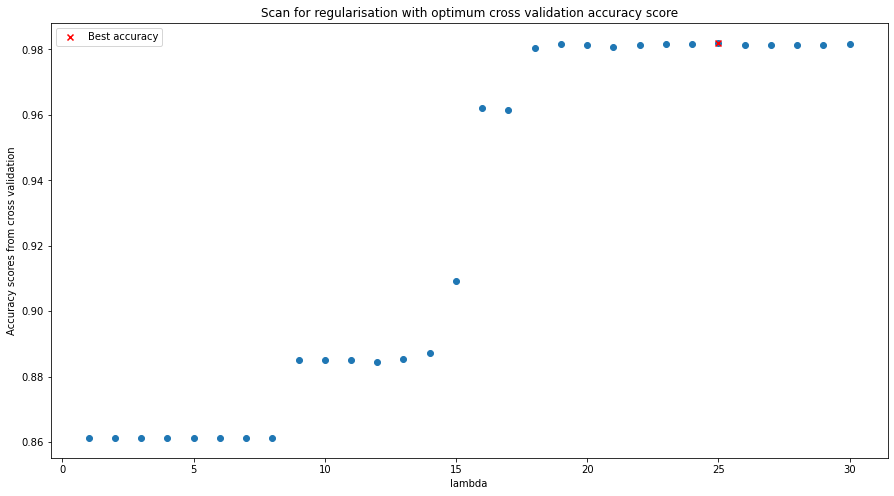

(25.0, 0.982066276803119)

In [535]:
#observe trend of steps and jumps
choose_best_reg(np.concatenate((stdXtrain,y_train[:,np.newaxis]),axis=1), 5, np.linspace(1,30,30),show=True,printing=True)

We notice an interesting step pattern emerging. Since the penalty parameter represents misclassification or error term and the misclassification or error term tells the SVM optimisation how much error is bearable increasing lambda controls the trade-off between decision boundary and misclassification term specifically decreasing the misclassification and hence increasing accuracy.

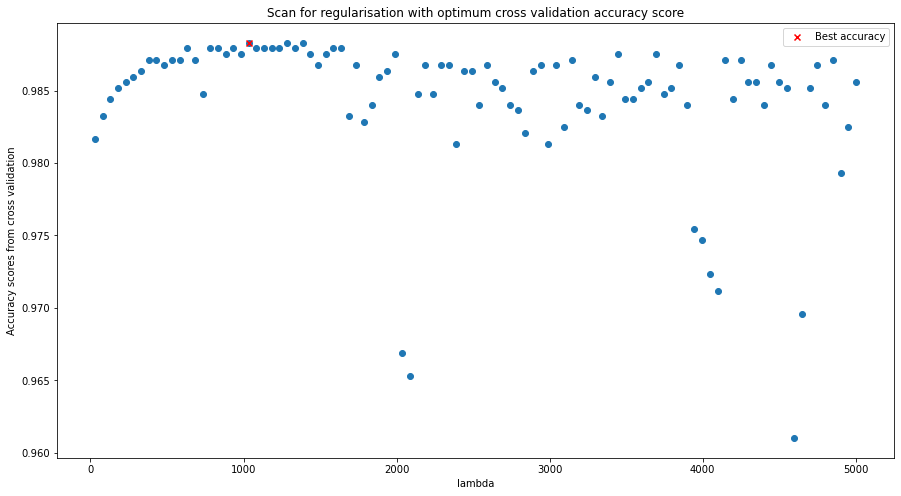

(1034.0404040404042, 0.9883040935672514)


In [536]:
#find optimum
optsvm = choose_best_reg(np.concatenate((stdXtrain,y_train[:,np.newaxis]),axis=1), 5, np.linspace(30,5000,100),show=True,printing=False)
print(optsvm)

In [553]:
print("Optimum regularisation:",optsvm[0],"giving CV accuracy:",optsvm[1])

Optimum regularisation: 1034.0404040404042 giving CV accuracy: 0.9883040935672514


We see that it is not as straightforward as the harder the regularisation the better the accuracy. This is since increasing $\lambda$ can lead to chance of overfitting and hence reducing accuracy.

The main idea that separates why we use a hard margin and a soft margin SVM lies in the separability of the data. If our data is linearly separable, we choose a hard margin. However, if it is not, it is just not feasible to use hard SVMs. When there are data points that make it not possible to find a perfectly separating hyper-plane, we would have to be more accepting and allow some of the data points to be misclassified. In this case, a soft margin SVM is appropriate. We sometimes have the case that the data is indeed linearly separable, but the street width is so small that the model can become prone to overfitting or being overly-sensitive to outliers and large noise. Again, we could select a larger margin by using a lower regularisation term and so softer margin SVM in order to help the model generalize better.

In order for us to get more information about the probability of an input being classified as 1 or -1 we will use Platt Scaling, a technique that maps the distances from the hyper-plane to probabilities. We use the simplest form of Platt Scaling which reduces to the logistic function. $$
f(x) = \frac{1}{1+e^{-x}}
$$
We see that if we input distance to the hyper-plane into the logistic function we end up with a value between 0 and 1. Importantly, if the distance is positive then the probability the distance is mapped to is greater than 0.5 (see logistic plot below) and if the distance is negative then the probability is less than 0.5. We also can observe that if the distance is minutely above 0 (only just being classified as 1) then its probability is just over 0.5. Same thing goes for the distance being just under 0. And very large distances are mapped to near 1 or near 0 depending on the sign of the distance. In other words, we can now get a sense of how close an input or certain an input is to being assigned a certain class. Notice, that the original classification scheme was using the sign of the distance. This corresponds to using p=0.5 as the classifying threshold probability boundary (classify as -1 if p<0.5, 1 otherwise). We can now move the probability threshold for classification which equates to moving the threshold distances for the hyper-plane. Using these probabilities we are able to produce a representation of the balance of errors in a graphical manner, using the ROC curve.

In [555]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

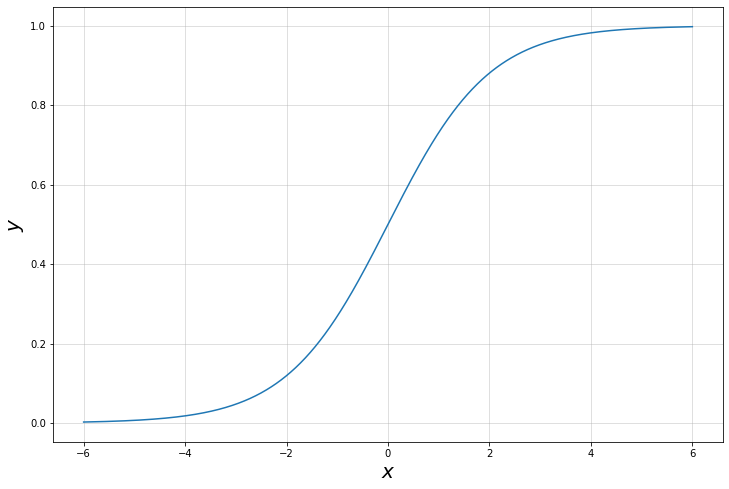

In [556]:
plt.figure(figsize=(12,8))
x = np.linspace(-6, 6, 1000)
y = logistic(x)
plt.xlabel(r'$x$', size=20)
plt.ylabel(r'$y$', size=20)
plt.grid(alpha=0.5)
plt.plot(x, y);

In [558]:
def roc_curve(y_true, y_prob):
    """
    Arguments:
    y_true: ground truth labels with size (n, )
    y_prob: probabilities produced by logistic function with size (n, )

    Returns:
    auc: area under the curve (AUC).
    tpr_l: a list of true positive rate (TPR) values for each scanned threshold.
    fpr_l: a list of false positive rate (FPR) values for each scanned threshold.
    thresholds: the scanned thresholds sorted descendingly.
    """
    
    # List of distinct values in y_log, sorted descendingly.
    thresholds = reversed(sorted(set(y_prob)))
    tpr_l, fpr_l = [], []
    #changing to boolean for computation of rates (needed for bitwise and operator)
    mappedy_true = np.array(y_true==1.).astype("int")
    for threshold in thresholds:
        # Apply thresholding
        y_thresholded = (y_prob >= threshold)
        # true positives
        tp = np.sum(mappedy_true & y_thresholded)
        # true negatives
        tn = np.sum((~mappedy_true) & (~y_thresholded))
        # false positives
        fp = np.sum((~mappedy_true) & y_thresholded)
        # false negatives
        fn = np.sum(mappedy_true & (~y_thresholded))

        tpr = tp / (tp + fn) 
        fpr = fp / (tn + fp)
        tpr_l.append(tpr)
        fpr_l.append(fpr)

    # Compute AUC using Trapezoidal rule
    auc = np.trapz(tpr_l, fpr_l)
    return auc, tpr_l, fpr_l, thresholds

In [579]:
#plot roc curves for regularisation terms in l_range
def eval_performance(l_range,xtrain,y_train,plotroc=True):
    aucs = []
    if plotroc:
        plt.figure(figsize=(15,12))
        plt.plot([0, 1], [0, 1],'r--')
    for l in l_range:
        w = sgd(xtrain, y_train, batch_size=32, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=l, print_outcome=False)
        y_pred =  stdXtest @ w
        y_prob = logistic(y_pred)
        mappedy_test = np.array(y_test==1.).astype("int")
        auc, tpr, fpr, th = roc_curve(mappedy_test, y_prob)
        aucs.append(auc)
        if plotroc:
            plt.title(f"Receiver Operating Curve", size=20)
            ax = plt.subplot(111)
            plt.plot(fpr, tpr, label = f'$\lambda$={l}, AUC = {auc:0.8f}', linewidth = 1)
            plt.ylabel('TPR', size=20)
            plt.xlabel('FPR', size=20)
    if plotroc:
        plt.legend(ncol=4,labelspacing=0.005)
        plt.show()
    #get best auc and lambda
    ind = np.argmax(aucs)
    lambdamax = l_range[ind]
    m = np.max(aucs)
    out = (lambdamax,m)
    print(f"AUC maximising lambda:{lambdamax}, AUC = {m}")
    if not plotroc:
        plt.figure(figsize=(15,12))
        plt.title("AUC for Regularisation values")
        plt.scatter(l_range,aucs)
        plt.xlabel("lambda")
        plt.ylabel("AUC")
        plt.show()
   
    
    return out

We begin by explaining the interpretation of the ROC curve. A ROC curve displays the trade-off between recall (the true positive rate) and specificity (the true negative rate) at different classification thresholds. Lowering the classification threshold classifies more items as positive, thus increasing both False Positives and True Positives. Classifiers producing curves more in the top-left corner indicate a better performance. As a standard we show the performance of a random classifier that is expected to give points lying along the diagonal (FPR = TPR).\
We may compare different classifiers, by summarizing the performance of each classifier into a single measure. We will use the area under the ROC curve (AUC). It is the same as the probability that a randomly chosen positive instance is ranked higher than a randomly chosen negative instance, i.e. it is equivalent to the two sample Wilcoxon rank-sum statistic.

First, we mention that we cannot plot the ROC curves for all the hyper-parameters in our grid search as there is far too many of them and the roc curves start to become indistinguishable so we only select appropriate hyper-parameters.\
We begin by going plotting the ROC curves for every odd $\lambda$ less than 20 since this was our first grid search, in which we saw the step pattern and general increase of accuracy emerge. We see that we have a corresponding pattern here; for small $\lambda$, generally the greater the regularisation the greater the AUC and hence the better the degree or measure of separability and so accuracy. The model becomes more capable of distinguishing between classes and better at predicting 0 classes as 0 and 1 classes as 1. We also see the step behaviour in the AUC values; there are intervals of near constant AUC inbetween jumps.

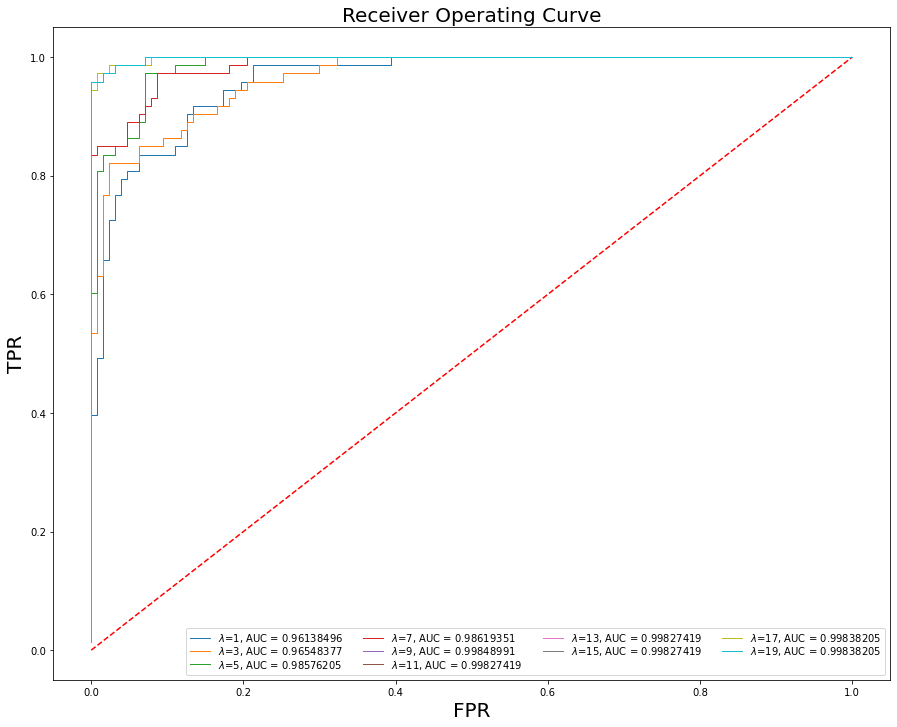

AUC maximising lambda:9, AUC = 0.9984899147880487


(9, 0.9984899147880487)

In [567]:
eval_performance(range(1,21,2),stdXtrain,y_train)

Next we plot for a variety of regularisation parameters. We plot for 1 and 10 since these were on their own step on the previous plots, we plot 25 and 100 since this is the start of the big level step, we plot the optimum regularisation and we plot 2500, 5000 to see if being further along this big level step is beneficial.

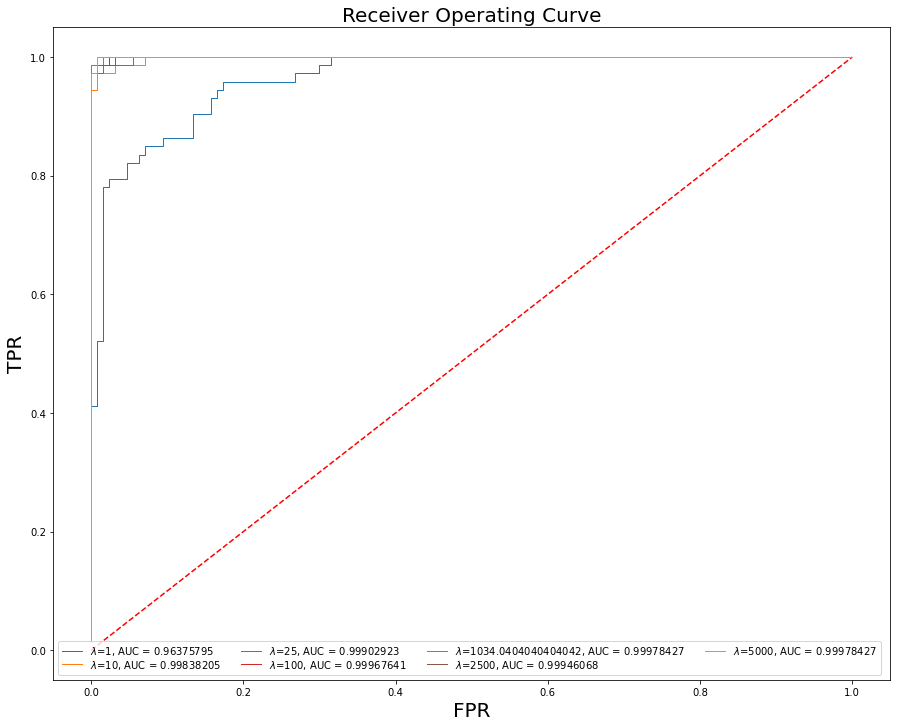

AUC maximising lambda:1034.0404040404042, AUC = 0.9997842735411498


(1034.0404040404042, 0.9997842735411498)

In [565]:
eval_performance([1,10,25,100,optsvm[0],2500,5000],stdXtrain,y_train)

The ROC curves gives us confirmation that the optimal regularisation is indeed optimal since it has the greates AUC which is near equal to 1, the perfect classifier. However, we see that the differences in AUC scores for other regularisation values are minutely smaller than for the optimal regularisation term. In addition, we see that first three values have clear steps in AUC just like the steps in CV accuracy. But along the big level step we see that making the hyper-parameter harder does not necessarilly make the classifier better, as AUC does not increase, perhaps due to overfitting. The lower regularisation classifiers (<20) seem to also show worse performance in the ROC curve with worse AUCs.

AUC maximising lambda:1212.878787878788, AUC = 1.0


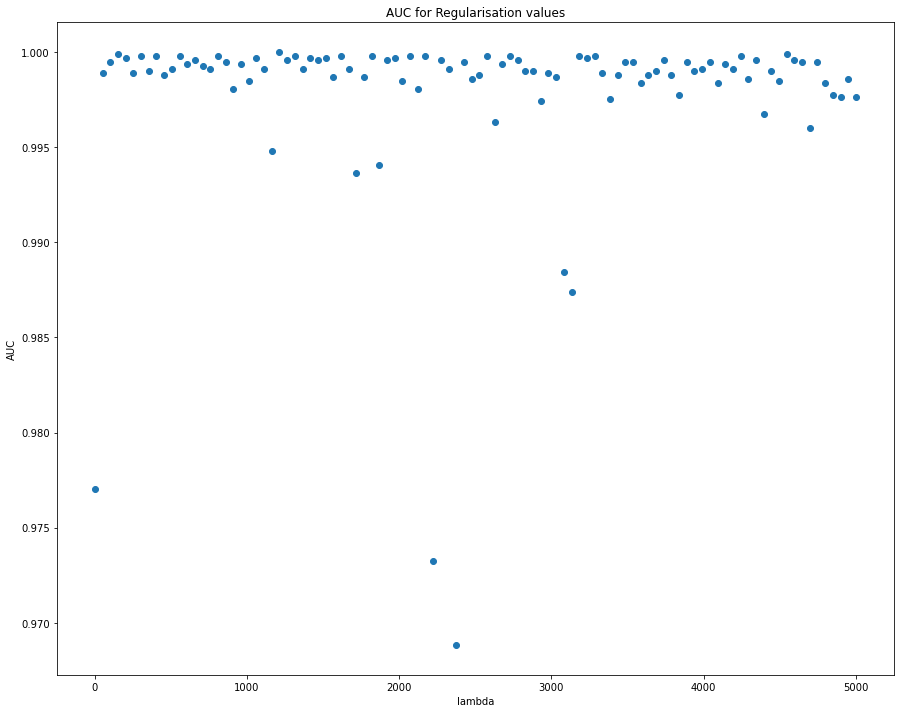

(1212.878787878788, 1.0)

In [580]:
eval_performance(np.linspace(1,5000,100),stdXtrain,y_train,plotroc=False)

We plot the AUCs for the same grid search and see a very similar pattern to that of the grid search which is since CV accuracy is directly related to the AUC from the TPR and FPR. We can again verify that the optimal regularisation is not necessarily the greatest in value, due to overfitting.

We repeat the previous task on a a balanced train set.

In [581]:
# load new balanced data as pandas data frames
tum_bal = pd.read_csv('tumour_samples_bal.csv')
tum_test = pd.read_csv("tumour_test.csv")
#removed extra index column and convert DIAGNOSIS to 1, -1
tum_bal.drop(tum_bal.columns[0], axis=1, inplace=True)
tum_test.drop(tum_test.columns[0], axis=1, inplace=True)
diag_map = {'M': 1.0, 'B': -1.0}
tum_bal['DIAGNOSIS'] = tum_bal['DIAGNOSIS'].map(diag_map)
tum_test['DIAGNOSIS'] = tum_test['DIAGNOSIS'].map(diag_map)
#load data into numpy
X_trainbal = tum_bal.to_numpy()[:,:-1]
y_trainbal = tum_bal.to_numpy()[:,-1]
X_test = tum_test.to_numpy()[:,:-1]
y_test = tum_test.to_numpy()[:,-1]

In [582]:
np.random.seed(10)
p = np.random.permutation(X_trainbal.shape[0])
X_trainbal = X_trainbal[p]
y_trainbal = y_trainbal[p]

In [583]:
#create a standardized X_trainbal
stdXtrainbal, params = standardise(X_trainbal)
stdXtestbal = np.empty(X_test.shape)
#create a standardized X_test using the same shifts (mu,std) from the train data
for i in range(X_trainbal.shape[1]):
    mu, std = params[i]
    stdXtestbal[:,i] = (X_test[:,i]-mu)/std

In [584]:
#adding the 1 column to the right of X data for the intercept term
stdXtrainbal = np.concatenate((stdXtrainbal,np.ones((stdXtrainbal.shape[0],1))),axis=1)
stdXtestbal = np.concatenate((stdXtestbal,np.ones((stdXtestbal.shape[0],1))),axis=1)

In [586]:
# train the model with balanced set
#not as good
print("Balanced set training")
wbal = sgd(stdXtrainbal, y_trainbal, batch_size=32, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=1e3, print_outcome=True)
print("Training finished.")

# train the model with unbalanced set
print("Unbalanced set training")
w = sgd(stdXtrain, y_train, batch_size=32, max_iterations=2000, stop_criterion=0.01, learning_rate=1e-5, regul_strength=1e3, print_outcome=True)
print("Training finished.")

Balanced set training
Iteration is: 1, Cost is: 249.2603871287833
Iteration is: 2, Cost is: 179.1648352334842
Iteration is: 4, Cost is: 156.2482430091617
Iteration is: 8, Cost is: 123.31674668831211
Iteration is: 16, Cost is: 110.25806867028756
Iteration is: 32, Cost is: 95.0097036796532
Iteration is: 64, Cost is: 84.27161178348113
Iteration is: 128, Cost is: 74.10583615197835
Iteration is: 256, Cost is: 65.0667075451671
Iteration is: 512, Cost is: 60.648727850895845
Iteration is: 1024, Cost is: 59.84717136848655
Iteration is: 1999, Cost is: 60.54108136374964
Training finished.
Unbalanced set training
Iteration is: 1, Cost is: 404.4956029472467
Iteration is: 2, Cost is: 275.0769259298067
Iteration is: 4, Cost is: 200.34655437707207
Iteration is: 8, Cost is: 121.747034947898
Iteration is: 16, Cost is: 78.81787904984796
Iteration is: 32, Cost is: 67.10739143311771
Iteration is: 64, Cost is: 50.55699110771053
Iteration is: 128, Cost is: 46.21090330526312
Iteration is: 256, Cost is: 41.026

We notice for the balanced set cost is much greater.

In [587]:
print("Accuracy on balanced train set trained on balanced set: {}".format(score(wbal, stdXtrainbal, y_trainbal)))
print("Accuracy on test set trained on balanced set: {}".format(score(wbal, stdXtestbal, y_test)))

print("Accuracy on unbalanced train set trained on unbalanced set: {}".format(score(w, stdXtrain, y_train)))
print("Accuracy on test set trained on unbalanced set: {}".format(score(w, stdXtest, y_test)))

Accuracy on balanced train set trained on balanced set: 0.98125
Accuracy on test set trained on balanced set: 0.99
Accuracy on unbalanced train set trained on unbalanced set: 0.990257209664848
Accuracy on test set trained on unbalanced set: 0.99


In [588]:
# evaluate
foldsbal = cross_val_split(X_train.shape[0], 5)

In [589]:
#tesing that is works for lamba=1e3
val_scoresbal = cross_val_evaluate(np.concatenate((stdXtrainbal,y_trainbal[:,np.newaxis]),axis=1), 5,lam=1e3)
print("Cross-validation score for balanced training set:",val_scoresbal)
print("Cross-validation score for unbalanced training set:",val_scores)

Cross-validation score for balanced training set: 0.9725000000000001
Cross-validation score for unbalanced training set: 0.9883040935672514


CV_ACC@lambda=1.0: 0.91500
CV_ACC@lambda=2.0: 0.91500
CV_ACC@lambda=3.0: 0.91500
CV_ACC@lambda=4.0: 0.91500
CV_ACC@lambda=5.0: 0.91500
CV_ACC@lambda=6.0: 0.92250
CV_ACC@lambda=7.0: 0.92375
CV_ACC@lambda=8.0: 0.92250
CV_ACC@lambda=9.0: 0.94250
CV_ACC@lambda=10.0: 0.94500
CV_ACC@lambda=11.0: 0.94875
CV_ACC@lambda=12.0: 0.95000
CV_ACC@lambda=13.0: 0.95000
CV_ACC@lambda=14.0: 0.96000
CV_ACC@lambda=15.0: 0.96125
CV_ACC@lambda=16.0: 0.96000
CV_ACC@lambda=17.0: 0.96000
CV_ACC@lambda=18.0: 0.96125
CV_ACC@lambda=19.0: 0.96000
CV_ACC@lambda=20.0: 0.96000
CV_ACC@lambda=21.0: 0.96125
CV_ACC@lambda=22.0: 0.96125
CV_ACC@lambda=23.0: 0.96125
CV_ACC@lambda=24.0: 0.96125
CV_ACC@lambda=25.0: 0.96125
CV_ACC@lambda=26.0: 0.96250
CV_ACC@lambda=27.0: 0.96250
CV_ACC@lambda=28.0: 0.96250
CV_ACC@lambda=29.0: 0.96250
CV_ACC@lambda=30.0: 0.96250


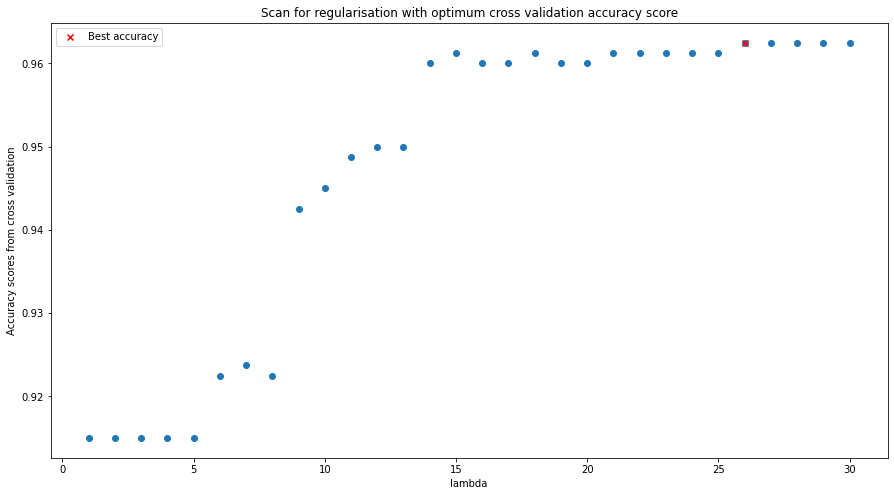

(26.0, 0.9625)

In [590]:
#trend of increasing score for small lambda
choose_best_reg(np.concatenate((stdXtrainbal,y_trainbal[:,np.newaxis]),axis=1), 5, np.linspace(1,30,30),show=True,printing=True)

We see the same sort of step pattern occuring except with an added step and the range of the top and bottom step different. The bottom step now starts much higher at around 0.92 accuracy compared to 0.86 for the unbalanced set. Further, the top step sits slightly lower at 0.96 accuracy compared to 0.98 for the unbalanced set.

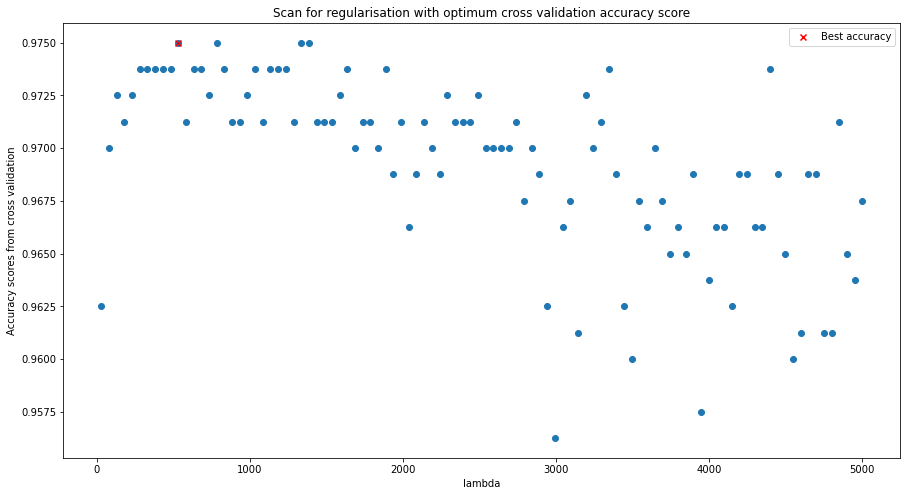

(532.0202020202021, 0.975)


In [591]:
#repeat for other grid search
optsvmbal = choose_best_reg(np.concatenate((stdXtrainbal,y_trainbal[:,np.newaxis]),axis=1), 5, np.linspace(30,5000,100),show=True,printing=False)
print(optsvmbal)

In [594]:
print("Optimum regularisation in balanced set:",optsvmbal[0],"giving CV accuracy:",optsvmbal[1])

Optimum regularisation in balanced set: 532.0202020202021 giving CV accuracy: 0.975


So we see for the balanced set that the regularisation term almost halves from 1034 to 532 and the CV accuracy decreases from 0.988 to 0.975. We also see that there is no level step for large values as with the unbalanced set. Further, the optimal regularisation term here gives a slightly worse CV accuracy that for the unabalanced set.

AUC maximising lambda:3586.1414141414143, AUC = 0.999892136770575


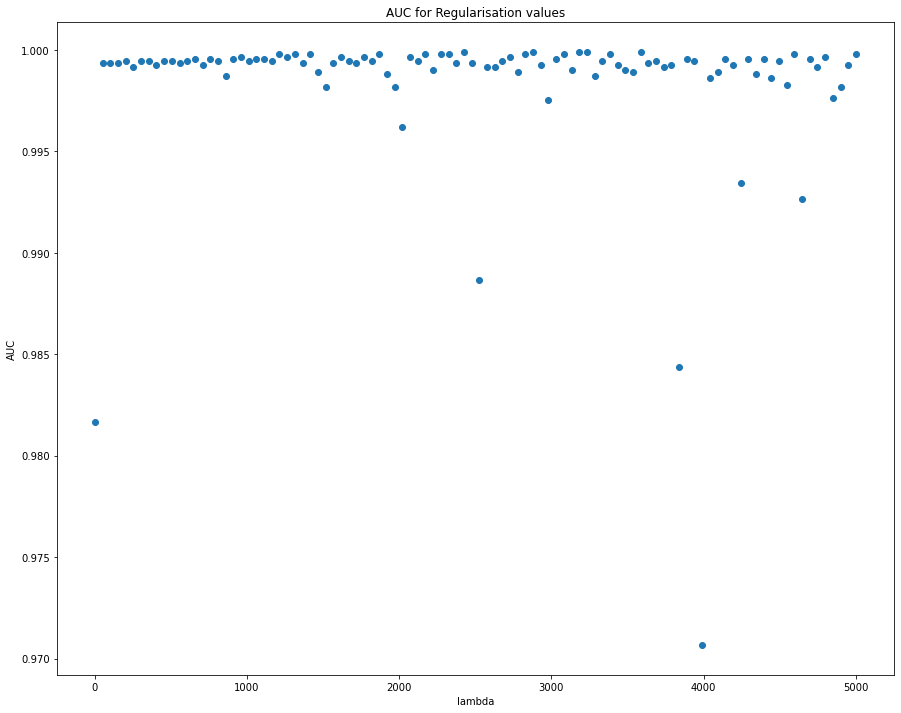

(3586.1414141414143, 0.999892136770575)

In [595]:
eval_performance(np.linspace(1,5000,100),stdXtrainbal,y_trainbal,plotroc=False)

Interestingly, even though we see no level step for large values in the grid search for CV accuracy we still see a level step in AUCs with fewer sharp dips than in the unbalanced set, showing more stability of the classifier when using a balanced set.

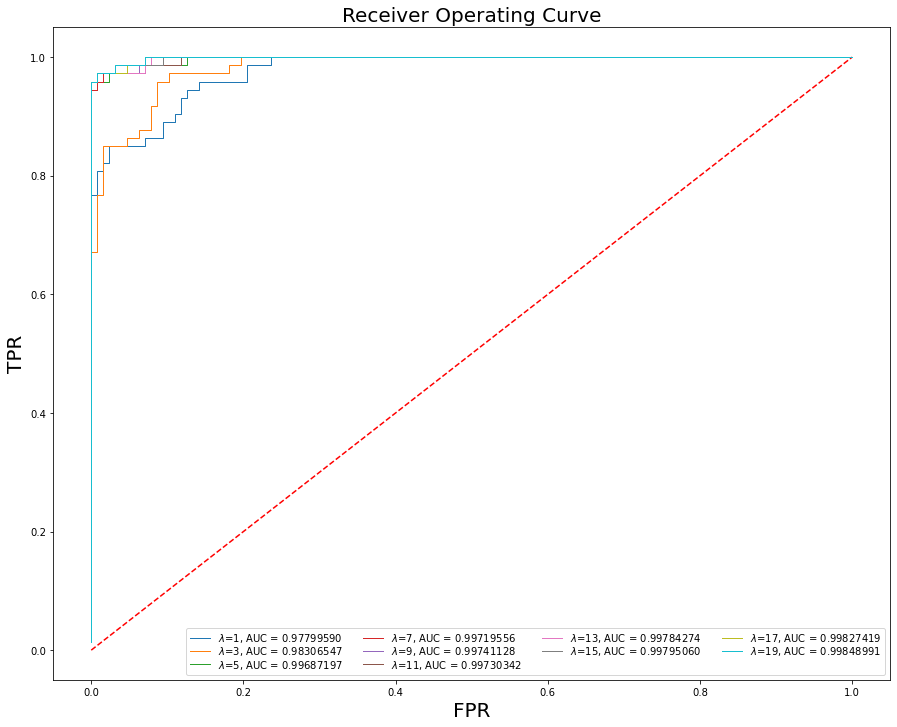

AUC maximising lambda:19, AUC = 0.9984899147880487


(19, 0.9984899147880487)

In [598]:
eval_performance(range(1,21,2),stdXtrainbal,y_trainbal)

For smaller $\lambda$ we again see a general increase in AUCs as the regularisation increases and again with jumps and steps but this time the starting AUCs for the smallest regularisation values are much higher when training the classifier on the balanced set rather than unbalanced. For example, the AUC for $\lambda = 1$ increases from 0.961 to 0.978. However, by the time we are over 15 we see that results are similar. For example, both  $\lambda = 19$ AUCs are equal to 0.998.

For small lambda values we see better results for the AUCs in the balanced set.

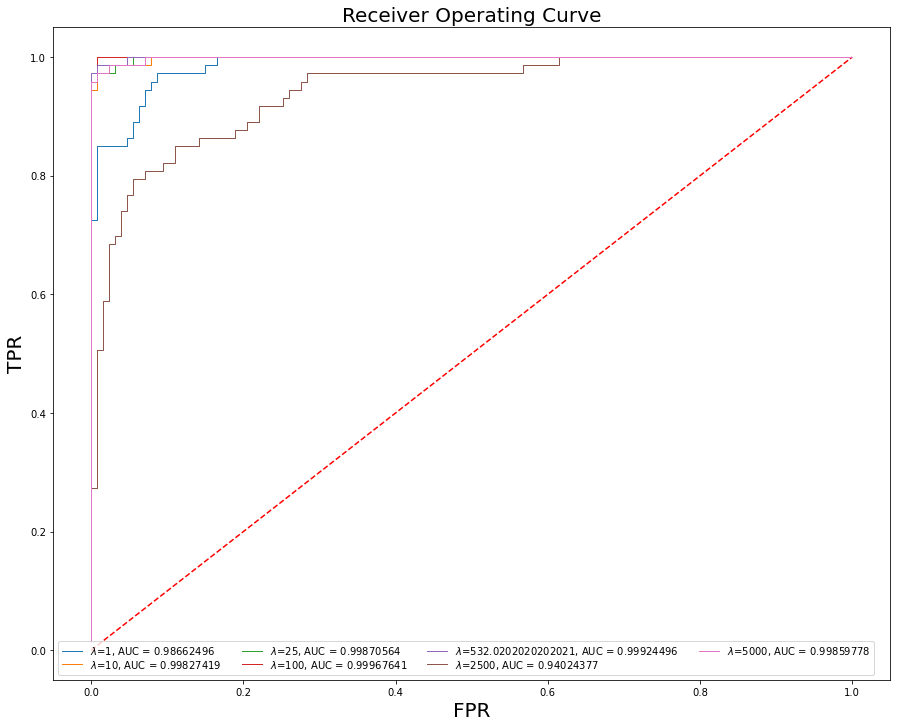

AUC maximising lambda:100, AUC = 0.9996764103117247


(100, 0.9996764103117247)

In [599]:
eval_performance([1,10,25,100,optsvmbal[0],2500,5000],stdXtrain,y_train)

Interestingly, we notice that the optimum regularisation for the grid search does not give the best AUC. In fact $\lambda=100$ which is 5 times less than the optimum gives a higher AUC. However, the AUC difference is minute (0.99967 - 0.99924) so we still argue that the optimum from the grid search is near optimum in this measure and so would procede to use it.

Overall, there are three main differences in the performance of the classifiers trained on the balanced and unbalanced train sets. Firstly, for small regularisation values (<20) we see that both in CV accuracy and AUCs the classifiers from the balanced set outperform those of the unbalanced set by a margin of around 0.5 in CV accuracy and 0.1 in AUCs. Secondly, for regularisation values bigger than 20, the performance in CV accuracy of the classifiers from the balanced set is much more erratic and unstable than from the unbalanced set as seen from the absence of a level step seen in the balanced set. However, this did not translate to AUCs where in fact there were less regularisation values, trained on the balanced set, that resulted in sharp low dips from around 0.999 than classifiers trained on the unbalanced set. Further, the size of these dips was much greater for the unbalanced set classifiers, with many dips reaching 0.975 compared to a low of 0.985 for classifiers trained on the balanced data. Lastly, again for $\lambda \geq 20$, we may notice that the optimal regularisations of classifiers from the balanced set never outperform those from the unbalanced set. We see in CV accuracy that the classifiers from the balanced set do not top 0.975 whereas the majority of classifiers trained on the unbalanced set are over 0.985 with the optimal regularisation attaining 0.988. The performance difference is less when measuring AUCs as the classifiers from the balanced set and unbalanced set both score incredibly highly in AUCs both averaging around 0.999 but the optimum of classifiers trained on the unbalanced set (1.0 to 16 s.f) is greater than the optimum of classifiers trained on the balanced set (0.99989).\
To summarise, for $\lambda \leq 20$ classifiers performed better when trained on balanced data, for $\lambda \geq 20$, classifier performance was less consistent in CV accuracy but more consistent in AUC scores but also worse scoring in CV accuracy and similar scoring AUCs when trained on balanced data rather than unbalanced.

<a name="task-3"></a>

# Task 3: Mastery Component [^](#outline)

<a name="q31"></a>

## 3.1 [^](#outline)

<a name="q32"></a>

## 3.2 [^](#outline)